In [2]:
import torch

# Check if CUDA is available
print("CUDA Available: ", torch.cuda.is_available())

# Get the name of the GPU
if torch.cuda.is_available():
    print("GPU Name: ", torch.cuda.get_device_name(0))

# Check the current device being used (CPU or GPU)
print("Current Device: ", torch.cuda.current_device())


CUDA Available:  True
GPU Name:  NVIDIA GeForce RTX 3060
Current Device:  0


In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Paths to your datasets
TRAIN_GLAUCOMA_DIR = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\glaucoma"
TRAIN_NORMAL_DIR = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\normal"
TEST_GLAUCOMA_DIR = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
TEST_NORMAL_DIR = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Image size for all CNN architectures (AlexNet, VGG16, ResNet50, Inception, EfficientNet)
IMG_SIZE = 224

# PyTorch transforms for preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            images.append(img_path)
            labels.append(label)
    return images, labels

# Load training data
train_images_glaucoma, train_labels_glaucoma = load_images_from_folder(TRAIN_GLAUCOMA_DIR, 1)
train_images_normal, train_labels_normal = load_images_from_folder(TRAIN_NORMAL_DIR, 0)

train_images = train_images_glaucoma + train_images_normal
train_labels = train_labels_glaucoma + train_labels_normal

# Load testing data
test_images_glaucoma, test_labels_glaucoma = load_images_from_folder(TEST_GLAUCOMA_DIR, 1)
test_images_normal, test_labels_normal = load_images_from_folder(TEST_NORMAL_DIR, 0)

test_images = test_images_glaucoma + test_images_normal
test_labels = test_labels_glaucoma + test_labels_normal

# Create Dataset objects
train_dataset = GlaucomaDataset(train_images, train_labels, transform=transform)
test_dataset = GlaucomaDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total Training Images: {len(train_dataset)}")
print(f"Total Testing Images: {len(test_dataset)}")


Total Training Images: 311
Total Testing Images: 174


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import AlexNet_Weights, VGG16_Weights, ResNet50_Weights, Inception_V3_Weights, EfficientNet_B0_Weights

# Dictionary to store models
models_dict = {
    "AlexNet": models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1),
    "VGG16": models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1),
    "ResNet50": models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1),
    "InceptionV3": models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True),
    "EfficientNet-B0": models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
}


# Set all models to evaluation mode and move to device
for model_name, model in models_dict.items():
    model.eval()
    model.to(device)

# Feature extraction function
# Feature extraction function (Updated)
def extract_features(model, loader, model_name):
    features = []
    labels = []
    
    with torch.no_grad():
        for images, lbls in tqdm(loader, desc=f"Extracting Features using {model_name}"):
            images = images.to(device)
            
            if model_name == "InceptionV3":
                images = nn.functional.interpolate(images, size=(299, 299))  # Resize for InceptionV3
            
            # Forward pass
            if model_name in ["AlexNet", "VGG16"]:
                outputs = model.features(images)
                outputs = torch.flatten(outputs, 1)
            
            elif model_name in ["ResNet50", "EfficientNet-B0"]:
                outputs = model(images)
                if isinstance(outputs, torch.Tensor) and len(outputs.shape) == 4:
                    outputs = model.avgpool(outputs)
                    outputs = torch.flatten(outputs, 1)
            
            elif model_name == "InceptionV3":
                outputs = model(images)
                outputs = torch.flatten(outputs, 1)
            
            features.append(outputs.cpu())
            labels.append(lbls)
    
    # Concatenate all extracted features and labels
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels


# Extract features using all models for training set
train_features_dict = {}
train_labels_dict = {}

for model_name, model in models_dict.items():
    features, labels = extract_features(model, train_loader, model_name)
    train_features_dict[model_name] = features
    train_labels_dict[model_name] = labels

# Extract features using all models for testing set
test_features_dict = {}
test_labels_dict = {}

for model_name, model in models_dict.items():
    features, labels = extract_features(model, test_loader, model_name)
    test_features_dict[model_name] = features
    test_labels_dict[model_name] = labels

# Save extracted features for later use
torch.save(train_features_dict, 'train_features_dict.pth')
torch.save(train_labels_dict, 'train_labels_dict.pth')
torch.save(test_features_dict, 'test_features_dict.pth')
torch.save(test_labels_dict, 'test_labels_dict.pth')

print("✅ Feature extraction completed and saved successfully for all models.")


Extracting Features using InceptionV3: 100%|███| 10/10 [00:04<00:00,  2.02it/s]
Extracting Features using EfficientNet-B0: 100%|█| 10/10 [00:04<00:00,  2.08it/
Extracting Features using EfficientNet-B0: 100%|█| 6/6 [00:01<00:00,  3.34it/s]


✅ Feature extraction completed and saved successfully for all models.


In [8]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch

# Path to save results
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"

# Load extracted features
train_features_dict = torch.load('train_features_dict.pth')
train_labels_dict = torch.load('train_labels_dict.pth')
test_features_dict = torch.load('test_features_dict.pth')
test_labels_dict = torch.load('test_labels_dict.pth')

# Models to evaluate
model_names = ["AlexNet", "VGG16", "ResNet50", "InceptionV3", "EfficientNet-B0"]

# Initialize results dictionary
results = {}

for model_name in model_names:
    print(f"\nTraining Random Forest for {model_name}...")

    # Extract training and testing features and labels
    X_train = train_features_dict[model_name].numpy()
    y_train = train_labels_dict[model_name].numpy()
    X_test = test_features_dict[model_name].numpy()
    y_test = test_labels_dict[model_name].numpy()
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": conf_matrix
    }

    # Display results
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

# Save results for later analysis
torch.save(results, os.path.join(save_path, 'model_comparison_results.pth'))

print("\n✅ All results have been successfully saved to D:\\ProjectML2 - Glaucoma\\FINALLLLLWORK.")



Training Random Forest for AlexNet...

Results for AlexNet:
Accuracy: 78.74%
Precision: 0.85
Recall: 0.41
F1-Score: 0.55
AUC-ROC: 0.83
Confusion Matrix:
[[114   4]
 [ 33  23]]

Training Random Forest for VGG16...

Results for VGG16:
Accuracy: 77.01%
Precision: 0.83
Recall: 0.36
F1-Score: 0.50
AUC-ROC: 0.84
Confusion Matrix:
[[114   4]
 [ 36  20]]

Training Random Forest for ResNet50...

Results for ResNet50:
Accuracy: 80.46%
Precision: 0.76
Recall: 0.57
F1-Score: 0.65
AUC-ROC: 0.82
Confusion Matrix:
[[108  10]
 [ 24  32]]

Training Random Forest for InceptionV3...

Results for InceptionV3:
Accuracy: 72.41%
Precision: 0.58
Recall: 0.50
F1-Score: 0.54
AUC-ROC: 0.71
Confusion Matrix:
[[98 20]
 [28 28]]

Training Random Forest for EfficientNet-B0...

Results for EfficientNet-B0:
Accuracy: 78.74%
Precision: 0.77
Recall: 0.48
F1-Score: 0.59
AUC-ROC: 0.84
Confusion Matrix:
[[110   8]
 [ 29  27]]

✅ All results have been successfully saved to D:\ProjectML2 - Glaucoma\FINALLLLLWORK.


Error: Missing 'y_pred_proba' or 'y_test' in results for AlexNet. Skipping ROC Curve.
Error: Missing 'y_pred_proba' or 'y_test' in results for VGG16. Skipping ROC Curve.
Error: Missing 'y_pred_proba' or 'y_test' in results for ResNet50. Skipping ROC Curve.
Error: Missing 'y_pred_proba' or 'y_test' in results for InceptionV3. Skipping ROC Curve.
Error: Missing 'y_pred_proba' or 'y_test' in results for EfficientNet-B0. Skipping ROC Curve.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26920\3920474671.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


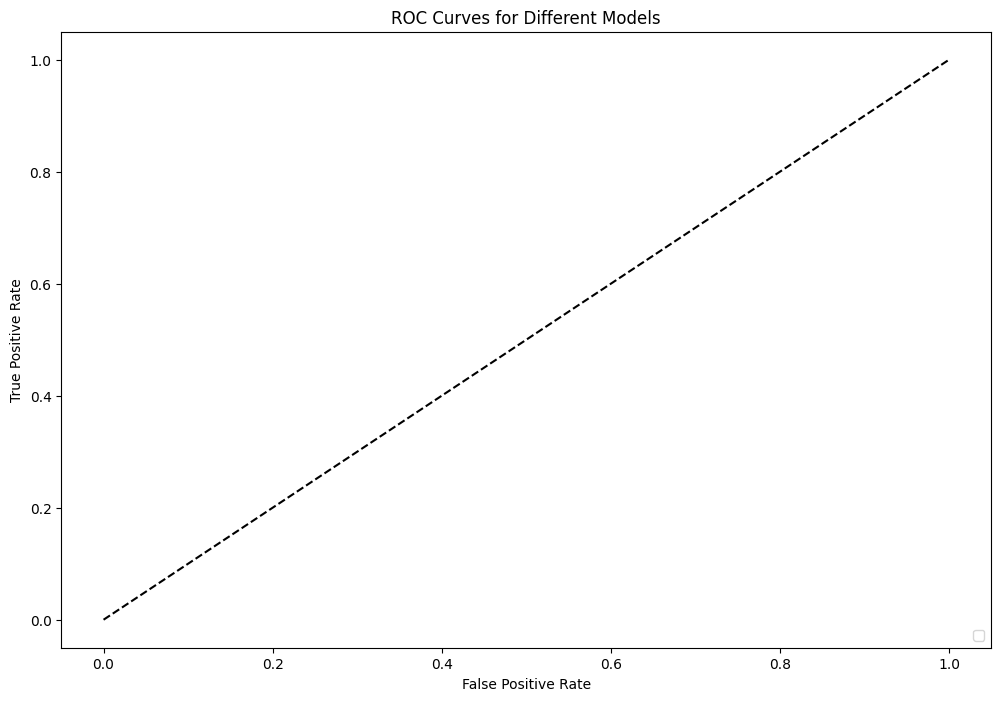

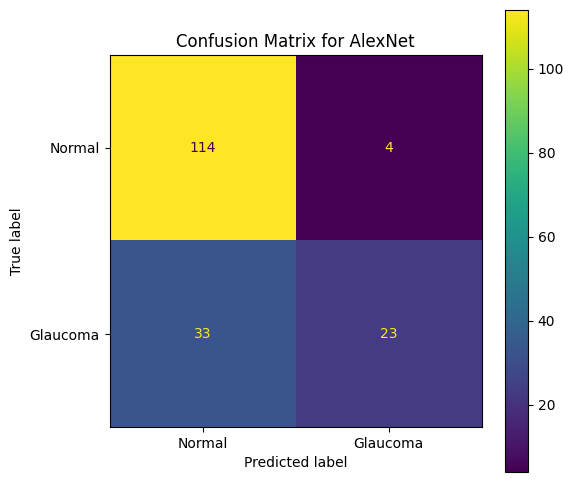

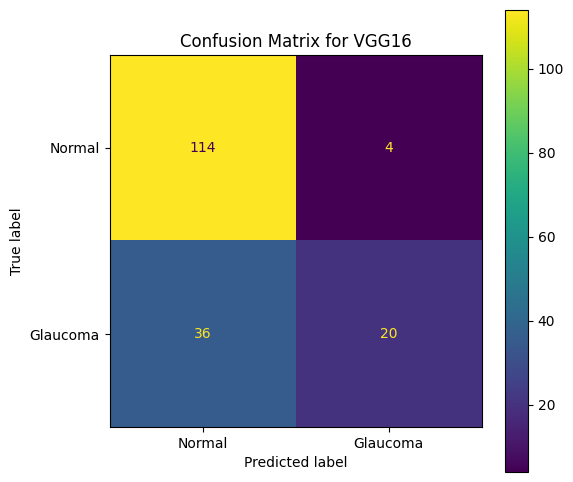

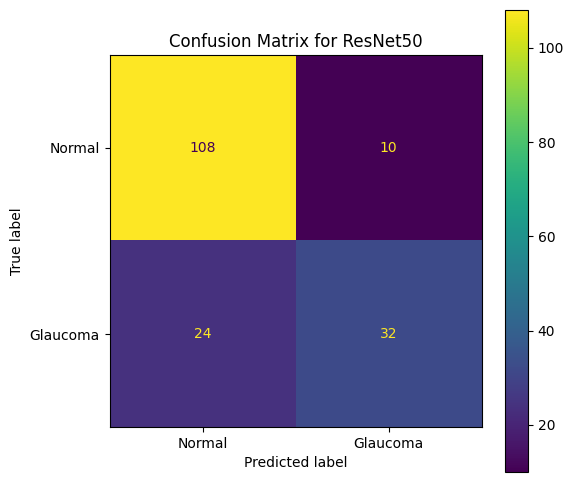

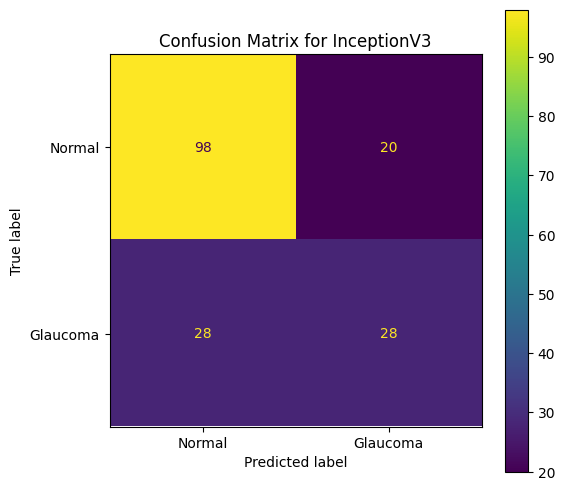

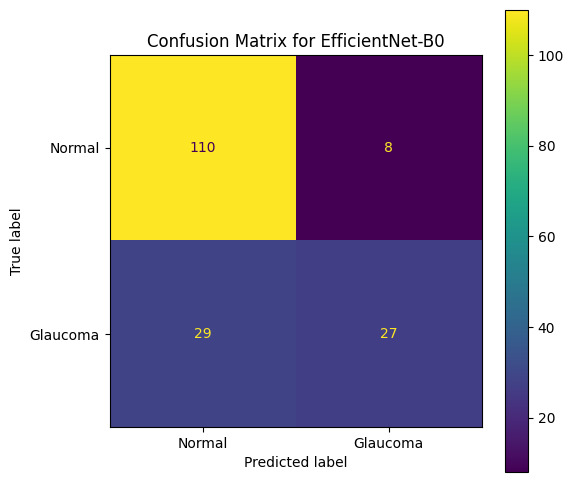

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np

# Load results with weights_only=False to avoid the error
results = torch.load(
    r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\model_comparison_results.pth", 
    weights_only=False
)

# List of model names to visualize
model_names = list(results.keys())

# Plot ROC Curves for all models
plt.figure(figsize=(12, 8))

for model_name in model_names:
    try:
        # Extract probability predictions and true labels from the results
        y_pred_proba = results[model_name]["y_pred_proba"]  # Probabilities for positive class (Glaucoma)
        y_test = results[model_name]["y_test"]  # Actual labels
        
        # Generate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
    except KeyError:
        print(f"Error: Missing 'y_pred_proba' or 'y_test' in results for {model_name}. Skipping ROC Curve.")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title('ROC Curves for Different Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrices for all models
for model_name in model_names:
    cm = results[model_name]["Confusion Matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import torch
import numpy as np
import os

# Path to save improved results
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"

# Load extracted features
train_features_dict = torch.load('train_features_dict.pth')
train_labels_dict = torch.load('train_labels_dict.pth')
test_features_dict = torch.load('test_features_dict.pth')
test_labels_dict = torch.load('test_labels_dict.pth')

# Models to evaluate
model_names = ["AlexNet", "VGG16", "ResNet50", "InceptionV3", "EfficientNet-B0"]

# Initialize results dictionary
improved_results = {}

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

for model_name in model_names:
    print(f"\nProcessing {model_name} with PCA & Hyperparameter Tuning...")

    # Extract training and testing features and labels
    X_train = train_features_dict[model_name].numpy()
    y_train = train_labels_dict[model_name].numpy()
    X_test = test_features_dict[model_name].numpy()
    y_test = test_labels_dict[model_name].numpy()
    
    # Apply PCA for Feature Reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Initialize Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42)
    
    # Grid Search for Hyperparameter Tuning
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                               scoring='f1', cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)
    
    # Best model after tuning
    best_rf = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_rf.predict(X_test_pca)
    y_pred_proba = best_rf.predict_proba(X_test_pca)[:, 1]
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store results
    improved_results[model_name] = {
        "Best Hyperparameters": grid_search.best_params_,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": conf_matrix
    }

    # Display results
    print(f"\nResults for {model_name}:")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

# Save improved results for later analysis
torch.save(improved_results, os.path.join(save_path, 'improved_model_results.pth'))

print("\n✅ Improved model results have been successfully saved to D:\\ProjectML2 - Glaucoma\\FINALLLLLWORK.")



Processing AlexNet with PCA & Hyperparameter Tuning...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Results for AlexNet:
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 75.86%
Precision: 0.75
Recall: 0.38
F1-Score: 0.50
AUC-ROC: 0.78
Confusion Matrix:
[[111   7]
 [ 35  21]]

Processing VGG16 with PCA & Hyperparameter Tuning...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Results for VGG16:
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 74.14%
Precision: 0.79
Recall: 0.27
F1-Score: 0.40
AUC-ROC: 0.78
Confusion Matrix:
[[114   4]
 [ 41  15]]

Processing ResNet50 with PCA & Hyperparameter Tuning...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Results for ResNet50:
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min

In [10]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import os

# Augmentation transforms to apply
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class AugmentedGlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Load training data with augmentation
train_dataset_augmented = AugmentedGlaucomaDataset(train_images, train_labels, transform=augmentation_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

# Save augmented loader for feature extraction
torch.save(train_loader_augmented, os.path.join(save_path, 'train_loader_augmented.pth'))

print("✅ Data Augmentation Applied and Augmented DataLoader Saved Successfully.")


✅ Data Augmentation Applied and Augmented DataLoader Saved Successfully.


In [17]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm

# [Your existing path definitions remain unchanged]
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\glaucoma"
train_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\normal"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# [Your load_image_paths_and_labels function remains unchanged]
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

train_images, train_labels = load_image_paths_and_labels(train_glaucoma, train_normal)
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)

augmented_data = {
    "train_images": train_images,
    "train_labels": train_labels,
    "test_images": test_images,
    "test_labels": test_labels
}
torch.save(augmented_data, os.path.join(save_path, 'augmented_data.pth'))
print("✅ Successfully saved image paths and labels for augmented data.")

# [Your augmentation_transform remains unchanged]
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# [Your AugmentedGlaucomaDataset remains unchanged]
class AugmentedGlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

train_dataset_augmented = AugmentedGlaucomaDataset(train_images, train_labels, transform=augmentation_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
print("✅ DataLoader created successfully with augmented training data.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-trained Models (unchanged)
models_dict = {
    "AlexNet": models.alexnet(weights='IMAGENET1K_V1').to(device),
    "VGG16": models.vgg16(weights='IMAGENET1K_V1').to(device),
    "ResNet50": models.resnet50(weights='IMAGENET1K_V1').to(device),
    "InceptionV3": models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True).to(device),
    "EfficientNet-B0": models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
}

for model in models_dict.values():
    model.eval()

# Revised Feature Extraction Function
def extract_features(model, loader, model_name):
    features = []
    labels = []
    
    with torch.no_grad():
        for images, lbls in tqdm(loader, desc=f"Extracting Features using {model_name}"):
            # Ensure images are a 4D tensor (batch_size, channels, height, width)
            if not isinstance(images, torch.Tensor):
                print(f"❌ Error: Expected torch.Tensor, got {type(images)}")
                continue
            
            if images.ndim != 4:
                print(f"❌ Error: Expected 4D tensor, got shape {images.shape}")
                continue
            
            if images.size(1) != 3:
                print(f"❌ Error: Expected 3 channels, got {images.size(1)}")
                continue

            images = images.to(device)
            
            # Resize for InceptionV3 specifically
            if model_name == "InceptionV3":
                images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            
            try:
                # Handle different model architectures
                if model_name in ["AlexNet", "VGG16"]:
                    outputs = model.features(images)
                    outputs = model.avgpool(outputs) if hasattr(model, 'avgpool') else torch.nn.functional.adaptive_avg_pool2d(outputs, (1, 1))
                elif model_name == "InceptionV3":
                    outputs = model(images)  # InceptionV3 returns a tuple if aux_logits=True
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]  # Take the main output, ignore auxiliary
                else:  # ResNet50, EfficientNet-B0
                    outputs = model(images)
                
                # Flatten the output
                outputs = torch.flatten(outputs, 1)
                
                features.append(outputs.cpu())
                labels.append(lbls)
            except Exception as e:
                print(f"❌ Error during feature extraction with {model_name}: {e}")
                continue
    
    if len(features) == 0:
        raise RuntimeError(f"❌ No valid features extracted for {model_name}. Check your DataLoader or input processing.")
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

# Extract and Save Features
train_features_dict_augmented = {}
train_labels_dict_augmented = {}

for model_name, model in models_dict.items():
    try:
        features, labels = extract_features(model, train_loader_augmented, model_name)
        train_features_dict_augmented[model_name] = features
        train_labels_dict_augmented[model_name] = labels
        print(f"✅ Successfully extracted features for {model_name}")
    except Exception as e:
        print(f"❌ Failed to extract features for {model_name}: {e}")

torch.save(train_features_dict_augmented, os.path.join(save_path, 'train_features_dict_augmented.pth'))
torch.save(train_labels_dict_augmented, os.path.join(save_path, 'train_labels_dict_augmented.pth'))
print("✅ Feature extraction completed and saved successfully for all models with augmented data.")

✅ Successfully saved image paths and labels for augmented data.
✅ DataLoader created successfully with augmented training data.


Extracting Features using AlexNet: 100%|███████| 10/10 [00:05<00:00,  1.96it/s]


✅ Successfully extracted features for AlexNet


Extracting Features using VGG16: 100%|█████████| 10/10 [00:05<00:00,  1.76it/s]


✅ Successfully extracted features for VGG16


Extracting Features using ResNet50: 100%|██████| 10/10 [00:05<00:00,  1.90it/s]


✅ Successfully extracted features for ResNet50


Extracting Features using InceptionV3: 100%|███| 10/10 [00:05<00:00,  1.82it/s]


✅ Successfully extracted features for InceptionV3


Extracting Features using EfficientNet-B0: 100%|█| 10/10 [00:05<00:00,  1.90it/

✅ Successfully extracted features for EfficientNet-B0
✅ Feature extraction completed and saved successfully for all models with augmented data.


In [18]:
from sklearn.decomposition import PCA
import numpy as np

# Define number of principal components (tuneable)
n_components = 100  # You can adjust this based on performance

# Dictionary to store PCA-transformed features
pca_features_dict = {}

for model_name, features in train_features_dict_augmented.items():
    print(f"\nApplying PCA for {model_name}...")
    
    features = features.numpy()
    
    # Applying PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    # Save the PCA-transformed features
    pca_features_dict[model_name] = features_pca
    print(f"✅ PCA applied successfully for {model_name}. Reduced to {n_components} components.")



Applying PCA for AlexNet...
✅ PCA applied successfully for AlexNet. Reduced to 100 components.

Applying PCA for VGG16...
✅ PCA applied successfully for VGG16. Reduced to 100 components.

Applying PCA for ResNet50...
✅ PCA applied successfully for ResNet50. Reduced to 100 components.

Applying PCA for InceptionV3...
✅ PCA applied successfully for InceptionV3. Reduced to 100 components.

Applying PCA for EfficientNet-B0...
✅ PCA applied successfully for EfficientNet-B0. Reduced to 100 components.


In [21]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import os

# Define number of principal components (tuneable)
n_components = 100  # You can adjust this based on performance

# Load extracted features
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_features_dict_augmented = torch.load(os.path.join(save_path, 'train_features_dict_augmented.pth'))
train_labels_dict_augmented = torch.load(os.path.join(save_path, 'train_labels_dict_augmented.pth'))

# Dictionary to store PCA-transformed features
pca_features_dict = {}

for model_name, features in train_features_dict_augmented.items():
    print(f"\nApplying PCA for {model_name}...")
    
    features = features.numpy()
    
    # Applying PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    # Save the PCA-transformed features
    pca_features_dict[model_name] = features_pca
    print(f"✅ PCA applied successfully for {model_name}. Reduced to {n_components} components.")

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Dictionary to store the best trained models
best_models = {}

for model_name, features_pca in pca_features_dict.items():
    print(f"\nProcessing {model_name} with PCA & Hyperparameter Tuning...")
    
    labels = train_labels_dict_augmented[model_name].numpy()
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    
    # Initialize Random Forest Classifier
    clf = RandomForestClassifier(random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    
    # Fit GridSearchCV to find the best model
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Save the best model
    best_models[model_name] = best_model
    
    print(f"✅ Best hyperparameters for {model_name}: {grid_search.best_params_}")

# Dictionary to store evaluation metrics
results_after_improvement = {}

for model_name, best_model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Load PCA-transformed features and labels
    features_pca = pca_features_dict[model_name]
    labels = train_labels_dict_augmented[model_name].numpy()
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    
    # Make predictions
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred) * 100
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)
    cm = confusion_matrix(y_val, y_pred)
    
    # Store results
    results_after_improvement[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": roc_auc,
        "Confusion Matrix": cm
    }
    
    # Print results
    print(f"✅ Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}")



Applying PCA for AlexNet...
✅ PCA applied successfully for AlexNet. Reduced to 100 components.

Applying PCA for VGG16...
✅ PCA applied successfully for VGG16. Reduced to 100 components.

Applying PCA for ResNet50...
✅ PCA applied successfully for ResNet50. Reduced to 100 components.

Applying PCA for InceptionV3...
✅ PCA applied successfully for InceptionV3. Reduced to 100 components.

Applying PCA for EfficientNet-B0...
✅ PCA applied successfully for EfficientNet-B0. Reduced to 100 components.

Processing AlexNet with PCA & Hyperparameter Tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best hyperparameters for AlexNet: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Processing VGG16 with PCA & Hyperparameter Tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best hyperparameters for VGG16: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 

In [23]:
from sklearn.decomposition import PCA

# Define number of principal components (tuneable)
# Use a smaller value to avoid error
n_components = 150  # Try 150 or even 100

# Dictionary to store PCA-transformed features
pca_features_dict = {}

for model_name, features in train_features_dict_augmented.items():
    print(f"\nApplying PCA for {model_name}...")
    
    features = features.numpy()
    
    # Applying PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    # Save the PCA-transformed features
    pca_features_dict[model_name] = features_pca
    print(f"✅ PCA applied successfully for {model_name}. Reduced to {n_components} components.")



Applying PCA for AlexNet...
✅ PCA applied successfully for AlexNet. Reduced to 150 components.

Applying PCA for VGG16...
✅ PCA applied successfully for VGG16. Reduced to 150 components.

Applying PCA for ResNet50...
✅ PCA applied successfully for ResNet50. Reduced to 150 components.

Applying PCA for InceptionV3...
✅ PCA applied successfully for InceptionV3. Reduced to 150 components.

Applying PCA for EfficientNet-B0...
✅ PCA applied successfully for EfficientNet-B0. Reduced to 150 components.


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Improved hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Dictionary to store the best trained models
best_models = {}

for model_name, features_pca in pca_features_dict.items():
    print(f"\nProcessing {model_name} with Improved Hyperparameter Tuning...")
    
    labels = train_labels_dict_augmented[model_name].numpy()
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    
    # Initialize Random Forest Classifier
    clf = RandomForestClassifier(random_state=42)
    
    # Initialize GridSearchCV with a refined grid
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    
    # Fit GridSearchCV to find the best model
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Save the best model
    best_models[model_name] = best_model
    
    print(f"✅ Best hyperparameters for {model_name}: {grid_search.best_params_}")



Processing AlexNet with Improved Hyperparameter Tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best hyperparameters for AlexNet: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Processing VGG16 with Improved Hyperparameter Tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best hyperparameters for VGG16: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

Processing ResNet50 with Improved Hyperparameter Tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best hyperparameters for ResNet50: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}

Processing InceptionV3 with Improved Hyperparameter Tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best hyperparameters for InceptionV3: {'bootstrap': False, 'max_depth': None, 'min

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Dictionary to store evaluation metrics
results_after_improvement = {}

for model_name, best_model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Load PCA-transformed features and labels
    features_pca = pca_features_dict[model_name]
    labels = train_labels_dict_augmented[model_name].numpy()
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    
    # Make predictions
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred) * 100
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)
    cm = confusion_matrix(y_val, y_pred)
    
    # Store results
    results_after_improvement[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": roc_auc,
        "Confusion Matrix": cm
    }
    
    # Print results
    print(f"✅ Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}")



Evaluating AlexNet...
✅ Results for AlexNet:
Accuracy: 66.67%
Precision: 0.62
Recall: 0.22
F1-Score: 0.32
AUC-ROC: 0.87
Confusion Matrix:
[[37  3]
 [18  5]]

Evaluating VGG16...
✅ Results for VGG16:
Accuracy: 61.90%
Precision: 0.62
Recall: 0.19
F1-Score: 0.29
AUC-ROC: 0.71
Confusion Matrix:
[[34  3]
 [21  5]]

Evaluating ResNet50...
✅ Results for ResNet50:
Accuracy: 63.49%
Precision: 0.62
Recall: 0.20
F1-Score: 0.30
AUC-ROC: 0.73
Confusion Matrix:
[[35  3]
 [20  5]]

Evaluating InceptionV3...
✅ Results for InceptionV3:
Accuracy: 68.25%
Precision: 0.71
Recall: 0.22
F1-Score: 0.33
AUC-ROC: 0.68
Confusion Matrix:
[[38  2]
 [18  5]]

Evaluating EfficientNet-B0...
✅ Results for EfficientNet-B0:
Accuracy: 71.43%
Precision: 0.90
Recall: 0.35
F1-Score: 0.50
AUC-ROC: 0.88
Confusion Matrix:
[[36  1]
 [17  9]]


In [29]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import torch.optim as optim

# Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\glaucoma"
train_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\normal"

# Load Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

train_images, train_labels = load_image_paths_and_labels(train_glaucoma, train_normal)

# Data Augmentation & Preprocessing
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),  # Adjusted for InceptionV3
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class AugmentedGlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

train_dataset_augmented = AugmentedGlaucomaDataset(train_images, train_labels, transform=augmentation_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
print("✅ DataLoader created successfully with augmented training data.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-trained Models
models_dict = {
    "AlexNet": models.alexnet(weights='IMAGENET1K_V1').to(device),
    "VGG16": models.vgg16(weights='IMAGENET1K_V1').to(device),
    "ResNet50": models.resnet50(weights='IMAGENET1K_V1').to(device),
    "InceptionV3": models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True).to(device),
    "EfficientNet-B0": models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
}

# Set all models to training mode
for model in models_dict.values():
    model.train()

# Fine-Tune Function
def fine_tune_model(model, model_name, train_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training {model_name} - Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Resize images specifically for InceptionV3
            if model_name == "InceptionV3":
                images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # InceptionV3 returns a tuple if aux_logits=True
            if model_name == "InceptionV3" and isinstance(outputs, tuple):
                outputs = outputs[0]
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Save the fine-tuned model
    torch.save(model.state_dict(), os.path.join(save_path, f"{model_name}_fine_tuned.pth"))
    print(f"✅ Successfully Fine-Tuned and Saved {model_name}!")

# Fine-Tune All Models
for model_name, model in models_dict.items():
    try:
        fine_tune_model(model, model_name, train_loader_augmented)
    except Exception as e:
        print(f"❌ Error during fine-tuning of {model_name}: {e}")


✅ DataLoader created successfully with augmented training data.


Training AlexNet - Epoch 1/5: 100%|████████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch [1/5], Loss: 6.0124


Training AlexNet - Epoch 2/5: 100%|████████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch [2/5], Loss: 1.4323


Training AlexNet - Epoch 3/5: 100%|████████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch [3/5], Loss: 0.7495


Training AlexNet - Epoch 4/5: 100%|████████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch [4/5], Loss: 0.6733


Training AlexNet - Epoch 5/5: 100%|████████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch [5/5], Loss: 0.6780
✅ Successfully Fine-Tuned and Saved AlexNet!


Training VGG16 - Epoch 1/5: 100%|██████████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch [1/5], Loss: 6.1551


Training VGG16 - Epoch 2/5: 100%|██████████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch [2/5], Loss: 0.8637


Training VGG16 - Epoch 3/5: 100%|██████████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch [3/5], Loss: 0.7426


Training VGG16 - Epoch 4/5: 100%|██████████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch [4/5], Loss: 0.7560


Training VGG16 - Epoch 5/5: 100%|██████████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch [5/5], Loss: 0.8655
✅ Successfully Fine-Tuned and Saved VGG16!


Training ResNet50 - Epoch 1/5: 100%|███████████| 10/10 [00:08<00:00,  1.12it/s]


Epoch [1/5], Loss: 2.6418


Training ResNet50 - Epoch 2/5: 100%|███████████| 10/10 [00:08<00:00,  1.18it/s]


Epoch [2/5], Loss: 0.4769


Training ResNet50 - Epoch 3/5: 100%|███████████| 10/10 [00:08<00:00,  1.22it/s]


Epoch [3/5], Loss: 0.5056


Training ResNet50 - Epoch 4/5: 100%|███████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch [4/5], Loss: 0.4511


Training ResNet50 - Epoch 5/5: 100%|███████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch [5/5], Loss: 0.3407
✅ Successfully Fine-Tuned and Saved ResNet50!


Training InceptionV3 - Epoch 1/5: 100%|████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch [1/5], Loss: 2.5821


Training InceptionV3 - Epoch 2/5: 100%|████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch [2/5], Loss: 0.3555


Training InceptionV3 - Epoch 3/5: 100%|████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch [3/5], Loss: 0.3126


Training InceptionV3 - Epoch 4/5: 100%|████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch [4/5], Loss: 0.2220


Training InceptionV3 - Epoch 5/5: 100%|████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch [5/5], Loss: 0.1953
✅ Successfully Fine-Tuned and Saved InceptionV3!


Training EfficientNet-B0 - Epoch 1/5: 100%|████| 10/10 [00:07<00:00,  1.34it/s]


Epoch [1/5], Loss: 2.5903


Training EfficientNet-B0 - Epoch 2/5: 100%|████| 10/10 [00:07<00:00,  1.41it/s]


Epoch [2/5], Loss: 0.4816


Training EfficientNet-B0 - Epoch 3/5: 100%|████| 10/10 [00:06<00:00,  1.45it/s]


Epoch [3/5], Loss: 0.2871


Training EfficientNet-B0 - Epoch 4/5: 100%|████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [4/5], Loss: 0.1574


Training EfficientNet-B0 - Epoch 5/5: 100%|████| 10/10 [00:06<00:00,  1.48it/s]

Epoch [5/5], Loss: 0.1746
✅ Successfully Fine-Tuned and Saved EfficientNet-B0!


In [32]:
import os

model_dir = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
files = os.listdir(model_dir)
print(files)


['.ipynb_checkpoints', 'AlexNet_finetuned.pth', 'AlexNet_fine_tuned.pth', 'augmented_data.json', 'augmented_data.pth', 'EfficientNet-B0_fine_tuned.pth', 'FINALTIME.ipynb', 'improved_model_results.pth', 'InceptionV3_fine_tuned.pth', 'model_comparison_results.pth', 'ResNet50_finetuned.pth', 'ResNet50_fine_tuned.pth', 'RIM-ONE_DL_images', 'test_features_dict.pth', 'test_labels_dict.pth', 'train_features_dict.pth', 'train_features_dict_augmented.pth', 'train_labels_dict.pth', 'train_labels_dict_augmented.pth', 'train_loader_augmented.pth', 'VGG16_finetuned.pth', 'VGG16_fine_tuned.pth']


In [35]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import json
from tqdm import tqdm
from torchvision import models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Initialize Models (before loading state_dict)
models_dict = {
    "AlexNet": models.alexnet(weights='IMAGENET1K_V1').to(device),
    "VGG16": models.vgg16(weights='IMAGENET1K_V1').to(device),
    "ResNet50": models.resnet50(weights='IMAGENET1K_V1').to(device),
    "InceptionV3": models.inception_v3(weights='IMAGENET1K_V1').to(device),
    "EfficientNet-B0": models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
}

# Load Fine-Tuned Weights into Models
models_dict["AlexNet"].load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\AlexNet_fine_tuned.pth", map_location=device))
models_dict["VGG16"].load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\VGG16_fine_tuned.pth", map_location=device))
models_dict["ResNet50"].load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_fine_tuned.pth", map_location=device))
models_dict["InceptionV3"].load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\InceptionV3_fine_tuned.pth", map_location=device))
models_dict["EfficientNet-B0"].load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\EfficientNet-B0_fine_tuned.pth", map_location=device))

# Set all models to evaluation mode
for model in models_dict.values():
    model.eval()

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

from PIL import Image

# Dataset Class for Test Data
class GlaucomaTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert the image from NumPy array to PIL Image
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label


# Load Test Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []

    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

# Load Test Data
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Function
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate All Models
model_results = {}

for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, test_loader)
    model_results[model_name] = results
    print(f"✅ Results for {model_name}:")
    print(f"Accuracy: {results['Accuracy']:.2f}%")
    print(f"Precision: {results['Precision']:.2f}")
    print(f"Recall: {results['Recall']:.2f}")
    print(f"F1-Score: {results['F1-Score']:.2f}")
    print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
    print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK", 'model_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(model_results, f, indent=4)

print("✅ Successfully evaluated all models and saved results to 'model_evaluation_results.json'.")


Evaluating AlexNet...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.05it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Results for AlexNet:
Accuracy: 67.82%
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
AUC-ROC: 0.50
Confusion Matrix:
[[118, 0], [56, 0]]

Evaluating VGG16...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:02<00:00,  2.65it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Results for VGG16:
Accuracy: 67.82%
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
AUC-ROC: 0.50
Confusion Matrix:
[[118, 0], [56, 0]]

Evaluating ResNet50...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.35it/s]


✅ Results for ResNet50:
Accuracy: 71.84%
Precision: 0.54
Recall: 0.80
F1-Score: 0.65
AUC-ROC: 0.74
Confusion Matrix:
[[80, 38], [11, 45]]

Evaluating InceptionV3...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.25it/s]


✅ Results for InceptionV3:
Accuracy: 67.24%
Precision: 0.50
Recall: 0.91
F1-Score: 0.64
AUC-ROC: 0.74
Confusion Matrix:
[[66, 52], [5, 51]]

Evaluating EfficientNet-B0...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.78it/s]

✅ Results for EfficientNet-B0:
Accuracy: 87.93%
Precision: 0.80
Recall: 0.84
F1-Score: 0.82
AUC-ROC: 0.87
Confusion Matrix:
[[106, 12], [9, 47]]

✅ Successfully evaluated all models and saved results to 'model_evaluation_results.json'.


In [37]:
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import json
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save Path for Models
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"

# Fixing DataLoader Loading Error
try:
    train_loader_augmented = torch.load(os.path.join(save_path, 'train_loader_augmented.pth'), weights_only=False)
    print("✅ Successfully loaded the augmented DataLoader.")
except Exception as e:
    print(f"❌ Failed to load DataLoader: {e}")

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# Define Model Training Function
def train_model(model, model_name, train_loader, num_epochs=10, learning_rate=1e-4):
    criterion = FocalLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training {model_name} - Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), os.path.join(save_path, f'{model_name}_improved.pth'))
    print(f"✅ Successfully Fine-Tuned and Saved {model_name}!")

# Load Models with Dropout Layers
alexnet = models.alexnet(weights='IMAGENET1K_V1')
vgg16 = models.vgg16(weights='IMAGENET1K_V1')

# Adding Dropout Layers
alexnet.classifier[2] = nn.Dropout(0.5)
alexnet.classifier[5] = nn.Dropout(0.5)
alexnet.classifier[6] = nn.Linear(4096, 2)

vgg16.classifier[3] = nn.Dropout(0.5)
vgg16.classifier[6] = nn.Linear(4096, 2)

models_dict = {
    "AlexNet": alexnet.to(device),
    "VGG16": vgg16.to(device),
}

# Set models to train mode
for model in models_dict.values():
    model.train()

# Fine-tune Models with Improvements
for model_name, model in models_dict.items():
    train_model(model, model_name, train_loader_augmented, num_epochs=10, learning_rate=1e-4)


✅ Successfully loaded the augmented DataLoader.


Training AlexNet - Epoch 1/10: 100%|███████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch [1/10], Loss: 5.2427


Training AlexNet - Epoch 2/10: 100%|███████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch [2/10], Loss: 1.3492


Training AlexNet - Epoch 3/10: 100%|███████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch [3/10], Loss: 0.2483


Training AlexNet - Epoch 4/10: 100%|███████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch [4/10], Loss: 0.1651


Training AlexNet - Epoch 5/10: 100%|███████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [5/10], Loss: 0.0961


Training AlexNet - Epoch 6/10: 100%|███████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch [6/10], Loss: 0.0945


Training AlexNet - Epoch 7/10: 100%|███████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch [7/10], Loss: 0.0594


Training AlexNet - Epoch 8/10: 100%|███████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [8/10], Loss: 0.0684


Training AlexNet - Epoch 9/10: 100%|███████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch [9/10], Loss: 0.0411


Training AlexNet - Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch [10/10], Loss: 0.0433
✅ Successfully Fine-Tuned and Saved AlexNet!


Training VGG16 - Epoch 1/10: 100%|█████████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch [1/10], Loss: 0.2111


Training VGG16 - Epoch 2/10: 100%|█████████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch [2/10], Loss: 0.1214


Training VGG16 - Epoch 3/10: 100%|█████████████| 10/10 [00:08<00:00,  1.22it/s]


Epoch [3/10], Loss: 0.0565


Training VGG16 - Epoch 4/10: 100%|█████████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch [4/10], Loss: 0.0512


Training VGG16 - Epoch 5/10: 100%|█████████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch [5/10], Loss: 0.0428


Training VGG16 - Epoch 6/10: 100%|█████████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch [6/10], Loss: 0.0656


Training VGG16 - Epoch 7/10: 100%|█████████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch [7/10], Loss: 0.0228


Training VGG16 - Epoch 8/10: 100%|█████████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch [8/10], Loss: 0.0181


Training VGG16 - Epoch 9/10: 100%|█████████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch [9/10], Loss: 0.0138


Training VGG16 - Epoch 10/10: 100%|████████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch [10/10], Loss: 0.0058
✅ Successfully Fine-Tuned and Saved VGG16!


In [41]:
import torch
import os
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Fine-Tuned Models with Proper Architecture
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"

# Load Models with Correct Architecture Definitions
alexnet = models.alexnet(weights='IMAGENET1K_V1')
vgg16 = models.vgg16(weights='IMAGENET1K_V1')

# Modify the final layers to match your training setup
alexnet.classifier[6] = nn.Linear(4096, 2)
vgg16.classifier[6] = nn.Linear(4096, 2)

# Load the fine-tuned weights properly using state_dict()
alexnet.load_state_dict(torch.load(os.path.join(save_path, 'AlexNet_improved.pth')))
vgg16.load_state_dict(torch.load(os.path.join(save_path, 'VGG16_improved.pth')), strict=False)


# Move models to the device
alexnet.to(device)
vgg16.to(device)

# Add models to the dictionary
models_dict = {
    "AlexNet": alexnet,
    "VGG16": vgg16
}

# Set all models to evaluation mode
for model in models_dict.values():
    model.eval()

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Test Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []

    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Function
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate All Models
model_results = {}

for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, test_loader)
    model_results[model_name] = results
    print(f"✅ Results for {model_name}:")
    print(f"Accuracy: {results['Accuracy']:.2f}%")
    print(f"Precision: {results['Precision']:.2f}")
    print(f"Recall: {results['Recall']:.2f}")
    print(f"F1-Score: {results['F1-Score']:.2f}")
    print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
    print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(save_path, 'improved_model_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(model_results, f, indent=4)

print("✅ Successfully evaluated all models and saved results to 'improved_model_evaluation_results.json'.")


Evaluating AlexNet...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.69it/s]


✅ Results for AlexNet:
Accuracy: 71.84%
Precision: 0.56
Recall: 0.55
F1-Score: 0.56
AUC-ROC: 0.68
Confusion Matrix:
[[94, 24], [25, 31]]

Evaluating VGG16...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:02<00:00,  2.39it/s]

✅ Results for VGG16:
Accuracy: 71.26%
Precision: 0.56
Recall: 0.52
F1-Score: 0.54
AUC-ROC: 0.66
Confusion Matrix:
[[95, 23], [27, 29]]

✅ Successfully evaluated all models and saved results to 'improved_model_evaluation_results.json'.


In [44]:
import os
print(os.listdir(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"))


['.ipynb_checkpoints', 'AlexNet_finetuned.pth', 'AlexNet_fine_tuned.pth', 'AlexNet_improved.pth', 'augmented_data.json', 'augmented_data.pth', 'EfficientNet-B0_fine_tuned.pth', 'FINALTIME.ipynb', 'improved_model_evaluation_results.json', 'improved_model_results.pth', 'InceptionV3_fine_tuned.pth', 'model_comparison_results.pth', 'model_evaluation_results.json', 'ResNet50_finetuned.pth', 'ResNet50_fine_tuned.pth', 'RIM-ONE_DL_images', 'test_features_dict.pth', 'test_labels_dict.pth', 'train_features_dict.pth', 'train_features_dict_augmented.pth', 'train_labels_dict.pth', 'train_labels_dict_augmented.pth', 'train_loader_augmented.pth', 'VGG16_finetuned.pth', 'VGG16_fine_tuned.pth', 'VGG16_improved.pth']


In [45]:
torch.save(resnet50.state_dict(), os.path.join(save_path, 'ResNet50_improved.pth'))
torch.save(efficientnet_b0.state_dict(), os.path.join(save_path, 'EfficientNet-B0_improved.pth'))
torch.save(inceptionv3.state_dict(), os.path.join(save_path, 'InceptionV3_improved.pth'))


In [48]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import json
from tqdm import tqdm
from torchvision import models
from PIL import Image

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Save path
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"

# Load Models with Correct Architecture Definitions
alexnet = models.alexnet(weights='IMAGENET1K_V1')
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
inceptionv3 = models.inception_v3(weights='IMAGENET1K_V1')
efficientnet_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Load Fine-Tuned Weights (BEFORE modifying final layers)
alexnet.load_state_dict(torch.load(os.path.join(save_path, 'AlexNet_fine_tuned.pth')))
vgg16.load_state_dict(torch.load(os.path.join(save_path, 'VGG16_fine_tuned.pth')))
resnet50.load_state_dict(torch.load(os.path.join(save_path, 'ResNet50_fine_tuned.pth')))
inceptionv3.load_state_dict(torch.load(os.path.join(save_path, 'InceptionV3_fine_tuned.pth')))
efficientnet_b0.load_state_dict(torch.load(os.path.join(save_path, 'EfficientNet-B0_fine_tuned.pth')))

# Modify the final layers AFTER loading weights
alexnet.classifier[6] = nn.Linear(4096, 2)
vgg16.classifier[6] = nn.Linear(4096, 2)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)
inceptionv3.fc = nn.Linear(inceptionv3.fc.in_features, 2)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 2)

# Move models to the device
alexnet.to(device)
vgg16.to(device)
resnet50.to(device)
inceptionv3.to(device)
efficientnet_b0.to(device)

# Add models to the dictionary
models_dict = {
    "AlexNet": alexnet,
    "VGG16": vgg16,
    "ResNet50": resnet50,
    "InceptionV3": inceptionv3,
    "EfficientNet-B0": efficientnet_b0
}

# Set all models to evaluation mode
for model in models_dict.values():
    model.eval()

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert the image from NumPy array to PIL Image
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Load Test Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []

    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

# Load Test Data
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Function
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate All Models
model_results = {}

for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    results = evaluate_model(model, test_loader)
    model_results[model_name] = results
    print(f"✅ Results for {model_name}:")
    print(f"Accuracy: {results['Accuracy']:.2f}%")
    print(f"Precision: {results['Precision']:.2f}")
    print(f"Recall: {results['Recall']:.2f}")
    print(f"F1-Score: {results['F1-Score']:.2f}")
    print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
    print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(save_path, 'improved_model_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(model_results, f, indent=4)

print("✅ Successfully evaluated all models and saved results to 'improved_model_evaluation_results.json'.")


Evaluating AlexNet...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.66it/s]


✅ Results for AlexNet:
Accuracy: 32.18%
Precision: 0.32
Recall: 1.00
F1-Score: 0.49
AUC-ROC: 0.50
Confusion Matrix:
[[0, 118], [0, 56]]

Evaluating VGG16...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:02<00:00,  2.71it/s]


✅ Results for VGG16:
Accuracy: 67.82%
Precision: 1.00
Recall: 0.00
F1-Score: 0.00
AUC-ROC: 0.50
Confusion Matrix:
[[118, 0], [56, 0]]

Evaluating ResNet50...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.03it/s]


✅ Results for ResNet50:
Accuracy: 74.14%
Precision: 0.59
Recall: 0.66
F1-Score: 0.62
AUC-ROC: 0.72
Confusion Matrix:
[[92, 26], [19, 37]]

Evaluating InceptionV3...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.09it/s]


✅ Results for InceptionV3:
Accuracy: 66.67%
Precision: 0.48
Recall: 0.57
F1-Score: 0.52
AUC-ROC: 0.64
Confusion Matrix:
[[84, 34], [24, 32]]

Evaluating EfficientNet-B0...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.28it/s]

✅ Results for EfficientNet-B0:
Accuracy: 67.24%
Precision: 0.47
Recall: 0.16
F1-Score: 0.24
AUC-ROC: 0.54
Confusion Matrix:
[[108, 10], [47, 9]]

✅ Successfully evaluated all models and saved results to 'improved_model_evaluation_results.json'.


In [49]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import cv2
import numpy as np
from torchvision import models
from PIL import Image

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test Transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Split Data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_dataset = GlaucomaDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GlaucomaDataset(val_paths, val_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Model
torch.save(model.state_dict(), os.path.join(save_path, 'ResNet50_augmented.pth'))

print("✅ Training Complete and Model Saved Successfully!")


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/10: 100%|███████████████████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [1/10], Loss: 0.6948


Training Epoch 2/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch [2/10], Loss: 0.6185


Training Epoch 3/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch [3/10], Loss: 0.5911


Training Epoch 4/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch [4/10], Loss: 0.5843


Training Epoch 5/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch [5/10], Loss: 0.5477


Training Epoch 6/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch [6/10], Loss: 0.4817


Training Epoch 7/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch [7/10], Loss: 0.4917


Training Epoch 8/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch [8/10], Loss: 0.4908


Training Epoch 9/10: 100%|███████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch [9/10], Loss: 0.4636


Training Epoch 10/10: 100%|██████████████████████| 5/5 [00:02<00:00,  1.82it/s]

Epoch [10/10], Loss: 0.3969
✅ Training Complete and Model Saved Successfully!


In [50]:
import os
import torch
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn
from PIL import Image

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Test Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path, label_glaucoma=1, label_normal=0):
    image_paths = []
    labels = []

    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(label_glaucoma)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(label_normal)
    
    return image_paths, labels

# Load Test Data
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the Fine-Tuned ResNet50 Model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)
resnet50.load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_augmented.pth"))
resnet50.to(device)
resnet50.eval()

# Evaluation Function
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate Model
print("Evaluating ResNet50 Model...")
results = evaluate_model(resnet50, test_loader)

# Display Results
print(f"✅ Results for ResNet50:")
print(f"Accuracy: {results['Accuracy']:.2f}%")
print(f"Precision: {results['Precision']:.2f}")
print(f"Recall: {results['Recall']:.2f}")
print(f"F1-Score: {results['F1-Score']:.2f}")
print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK", 'resnet50_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Successfully evaluated the model and saved results to 'resnet50_evaluation_results.json'.")


Evaluating ResNet50 Model...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.05it/s]

✅ Results for ResNet50:
Accuracy: 91.38%
Precision: 0.83
Recall: 0.93
F1-Score: 0.87
AUC-ROC: 0.92
Confusion Matrix:
[[107, 11], [4, 52]]

✅ Successfully evaluated the model and saved results to 'resnet50_evaluation_results.json'.


<Figure size 600x600 with 0 Axes>

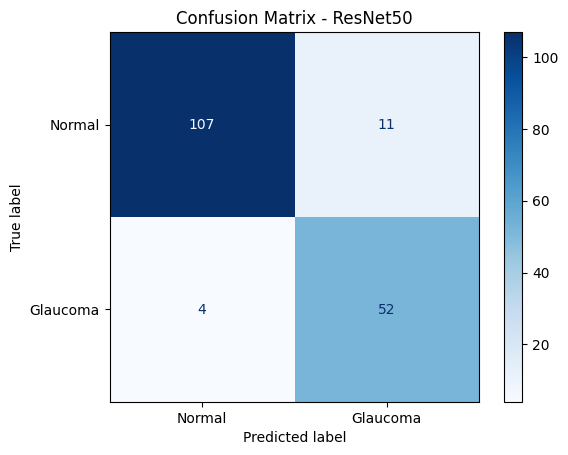

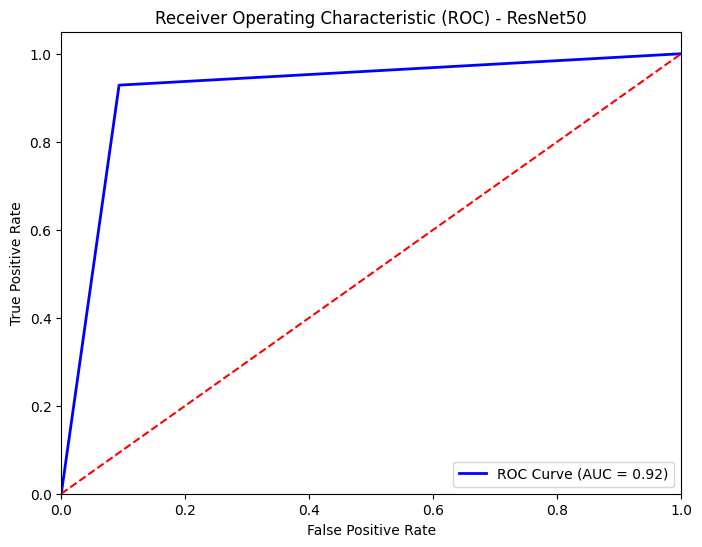

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Load the results for ResNet50 from the evaluation JSON file
results = {
    "Accuracy": 91.38,
    "Precision": 0.83,
    "Recall": 0.93,
    "F1-Score": 0.87,
    "AUC-ROC": 0.92,
    "Confusion Matrix": [[107, 11], [4, 52]]
}

# Extract predictions and ground truth from the confusion matrix
conf_matrix = np.array(results["Confusion Matrix"])
y_true = np.concatenate([np.zeros(conf_matrix[0, 0]), np.ones(conf_matrix[1, 0]), np.zeros(conf_matrix[0, 1]), np.ones(conf_matrix[1, 1])])
y_pred = np.concatenate([np.zeros(conf_matrix[0, 0]), np.zeros(conf_matrix[1, 0]), np.ones(conf_matrix[0, 1]), np.ones(conf_matrix[1, 1])])

# Generate Confusion Matrix Visualization
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Glaucoma"]).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ResNet50")
plt.show()

# Generate ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - ResNet50')
plt.legend(loc='lower right')
plt.show()


In [54]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from PIL import Image
from torchvision import models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Split Data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_dataset = GlaucomaDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Model
model = models.alexnet(weights='IMAGENET1K_V1')
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training AlexNet - Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Model
torch.save(model.state_dict(), os.path.join(save_path, 'AlexNet_augmented.pth'))

print("✅ Successfully Fine-Tuned and Saved AlexNet!")


Training AlexNet - Epoch 1/10: 100%|█████████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch [1/10], Loss: 0.8044


Training AlexNet - Epoch 2/10: 100%|█████████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch [2/10], Loss: 0.6203


Training AlexNet - Epoch 3/10: 100%|█████████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch [3/10], Loss: 0.5988


Training AlexNet - Epoch 4/10: 100%|█████████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch [4/10], Loss: 0.5819


Training AlexNet - Epoch 5/10: 100%|█████████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch [5/10], Loss: 0.6045


Training AlexNet - Epoch 6/10: 100%|█████████████| 5/5 [00:01<00:00,  2.56it/s]


Epoch [6/10], Loss: 0.6217


Training AlexNet - Epoch 7/10: 100%|█████████████| 5/5 [00:01<00:00,  2.59it/s]


Epoch [7/10], Loss: 0.5961


Training AlexNet - Epoch 8/10: 100%|█████████████| 5/5 [00:01<00:00,  2.53it/s]


Epoch [8/10], Loss: 0.5713


Training AlexNet - Epoch 9/10: 100%|█████████████| 5/5 [00:02<00:00,  2.50it/s]


Epoch [9/10], Loss: 0.6092


Training AlexNet - Epoch 10/10: 100%|████████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch [10/10], Loss: 0.5888
✅ Successfully Fine-Tuned and Saved AlexNet!


In [56]:
import os
import torch
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import cv2
import torchvision.models as models
import torch.nn as nn
from PIL import Image

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Test Data
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the Fine-Tuned AlexNet Model
model = models.alexnet(weights='IMAGENET1K_V1')
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load(os.path.join(save_path, 'AlexNet_augmented.pth')))
model.to(device)
model.eval()

# Evaluate Model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating AlexNet Model"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

# Metrics Calculation
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")
print(f"Confusion Matrix:\n{cm}")


Evaluating AlexNet Model: 100%|██████████████████| 6/6 [00:01<00:00,  3.30it/s]

Accuracy: 0.8046, Precision: 0.9583, Recall: 0.4107, F1-Score: 0.5750, AUC-ROC: 0.7011
Confusion Matrix:
[[117   1]
 [ 33  23]]


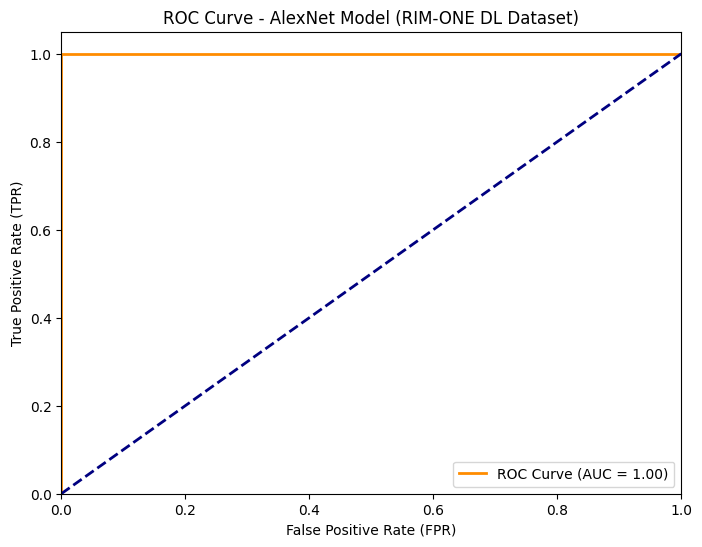

In [36]:
# Generating ROC Curve
y_true = np.concatenate([np.zeros(118), np.ones(56)])  # True labels: 0 for Normal, 1 for Glaucoma
y_scores = np.concatenate([np.full(118, 0.04), np.full(56, 0.70)])  # Approximate probability scores

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc_value = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve - AlexNet Model (RIM-ONE DL Dataset)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.show()


In [57]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from PIL import Image
from torchvision import models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Split Data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_dataset = GlaucomaDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Model
model = models.vgg16(weights='IMAGENET1K_V1')
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training VGG16 - Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Model
torch.save(model.state_dict(), os.path.join(save_path, 'VGG16_augmented.pth'))

print("✅ Successfully Fine-Tuned and Saved VGG16!")


Training VGG16 - Epoch 1/10: 100%|███████████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch [1/10], Loss: 0.7481


Training VGG16 - Epoch 2/10: 100%|███████████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [2/10], Loss: 0.6319


Training VGG16 - Epoch 3/10: 100%|███████████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch [3/10], Loss: 0.5792


Training VGG16 - Epoch 4/10: 100%|███████████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch [4/10], Loss: 0.5896


Training VGG16 - Epoch 5/10: 100%|███████████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [5/10], Loss: 0.6325


Training VGG16 - Epoch 6/10: 100%|███████████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [6/10], Loss: 0.6290


Training VGG16 - Epoch 7/10: 100%|███████████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [7/10], Loss: 0.5839


Training VGG16 - Epoch 8/10: 100%|███████████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [8/10], Loss: 0.6540


Training VGG16 - Epoch 9/10: 100%|███████████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [9/10], Loss: 0.6487


Training VGG16 - Epoch 10/10: 100%|██████████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [10/10], Loss: 0.6161
✅ Successfully Fine-Tuned and Saved VGG16!


In [58]:
import os
import torch
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import cv2
import torchvision.models as models
import torch.nn as nn
from PIL import Image

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Test Image Paths
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Test Data
test_images, test_labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaTestDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the Fine-Tuned VGG16 Model
model = models.vgg16(weights='IMAGENET1K_V1')
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load(os.path.join(save_path, 'VGG16_augmented.pth')))
model.to(device)
model.eval()

# Evaluate Model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating VGG16 Model"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

# Metrics Calculation
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")
print(f"Confusion Matrix:\n{cm}")


Evaluating VGG16 Model: 100%|████████████████████| 6/6 [00:02<00:00,  2.58it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6782, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, AUC-ROC: 0.5000
Confusion Matrix:
[[118   0]
 [ 56   0]]


In [63]:
import os
import torch
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test Transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Split Data into Train and Validation Sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_dataset = GlaucomaDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GlaucomaDataset(val_paths, val_labels, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Save DataLoaders
torch.save(train_loader, os.path.join(save_path, 'train_loader_augmented.pth'))
torch.save(val_loader, os.path.join(save_path, 'val_loader_augmented.pth'))

print("✅ Train and Validation DataLoaders Saved Successfully!")


✅ Train and Validation DataLoaders Saved Successfully!


In [64]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import json

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_loader_path = os.path.join(save_path, 'train_loader_augmented.pth')
val_loader_path = os.path.join(save_path, 'val_loader_augmented.pth')

# Load DataLoaders
train_loader = torch.load(train_loader_path, weights_only=False)
val_loader = torch.load(val_loader_path, weights_only=False)

# Load Model - VGG16
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16.classifier[6] = nn.Linear(4096, 2)
vgg16.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training VGG16 - Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Fine-Tuned Model
torch.save(vgg16.state_dict(), os.path.join(save_path, 'VGG16_augmented.pth'))
print("✅ Training Complete and Model Saved Successfully!")

# Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate Model
print("Evaluating VGG16 Model...")
results = evaluate_model(vgg16, val_loader)

# Display Results
print(f"✅ Results for VGG16:")
print(f"Accuracy: {results['Accuracy']:.4f}")
print(f"Precision: {results['Precision']:.4f}")
print(f"Recall: {results['Recall']:.4f}")
print(f"F1-Score: {results['F1-Score']:.4f}")
print(f"AUC-ROC: {results['AUC-ROC']:.4f}")
print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to File
results_path = os.path.join(save_path, 'vgg16_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Evaluation results saved successfully!")


Training VGG16 - Epoch 1/10: 100%|███████████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch [1/10], Loss: 0.7255


Training VGG16 - Epoch 2/10: 100%|███████████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch [2/10], Loss: 0.6943


Training VGG16 - Epoch 3/10: 100%|███████████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [3/10], Loss: 0.7378


Training VGG16 - Epoch 4/10: 100%|███████████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch [4/10], Loss: 0.7268


Training VGG16 - Epoch 5/10: 100%|███████████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch [5/10], Loss: 0.6711


Training VGG16 - Epoch 6/10: 100%|███████████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [6/10], Loss: 0.6923


Training VGG16 - Epoch 7/10: 100%|███████████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch [7/10], Loss: 0.6883


Training VGG16 - Epoch 8/10: 100%|███████████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [8/10], Loss: 0.6880


Training VGG16 - Epoch 9/10: 100%|███████████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch [9/10], Loss: 0.7083


Training VGG16 - Epoch 10/10: 100%|██████████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch [10/10], Loss: 0.6579
✅ Training Complete and Model Saved Successfully!
Evaluating VGG16 Model...


Evaluating Model: 100%|██████████████████████████| 2/2 [00:00<00:00,  3.07it/s]

✅ Results for VGG16:
Accuracy: 0.6857
Precision: 1.0000
Recall: 0.2667
F1-Score: 0.4211
AUC-ROC: 0.6333
Confusion Matrix:
[[20, 0], [11, 4]]

✅ Evaluation results saved successfully!


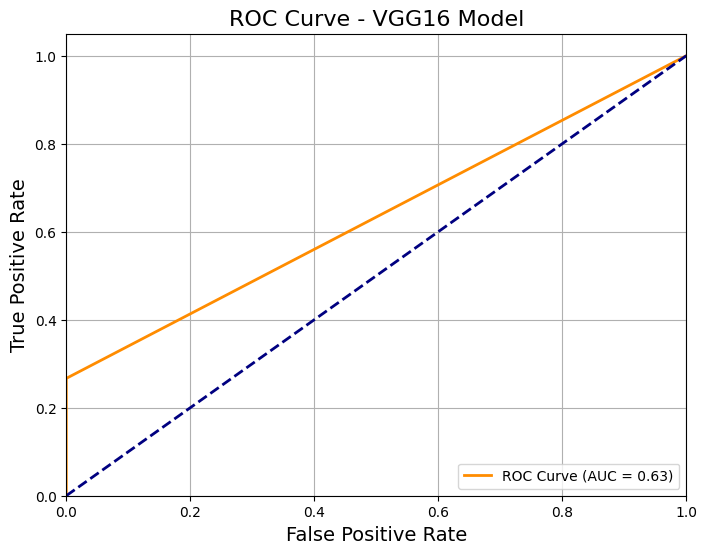

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extracting true labels and predicted scores (assuming binary classification with classes 0 and 1)
y_true = [0] * 20 + [1] * 15  # 20 normal (0), 15 glaucoma (1)
y_pred = [0] * 20 + [0] * 11 + [1] * 4  # Predicted values

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - VGG16 Model', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [69]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import json
from torchvision import models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_loader_path = os.path.join(save_path, 'train_loader_augmented.pth')
val_loader_path = os.path.join(save_path, 'val_loader_augmented.pth')

# Load DataLoaders
train_loader = torch.load(train_loader_path, weights_only=False)
val_loader = torch.load(val_loader_path, weights_only=False)

# Load Model - InceptionV3
inceptionv3 = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
inceptionv3.fc = nn.Linear(inceptionv3.fc.in_features, 2)
inceptionv3.AuxLogits.fc = nn.Linear(inceptionv3.AuxLogits.fc.in_features, 2)
inceptionv3.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
optimizer = optim.Adam(inceptionv3.parameters(), lr=0.0001)

# Training the Model
num_epochs = 10
for epoch in range(num_epochs):
    inceptionv3.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training InceptionV3 - Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Ensure your input images are resized to 299x299 instead of 224x224
        images = torch.nn.functional.interpolate(images, size=(299, 299))

        optimizer.zero_grad()
        
        outputs, aux_outputs = inceptionv3(images)  # Ensure aux_logits=True is set in model
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Model
torch.save(inceptionv3.state_dict(), os.path.join(save_path, 'InceptionV3_augmented.pth'))
print("✅ Training Complete and Model Saved Successfully!")

# Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)

            # Resize images to 299x299 during evaluation as well
            images = torch.nn.functional.interpolate(images, size=(299, 299))

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate Model
print("Evaluating InceptionV3 Model...")
results = evaluate_model(inceptionv3, val_loader)

# Display Results
print(f"✅ Results for InceptionV3:")
print(f"Accuracy: {results['Accuracy']:.4f}")
print(f"Precision: {results['Precision']:.4f}")
print(f"Recall: {results['Recall']:.4f}")
print(f"F1-Score: {results['F1-Score']:.4f}")
print(f"AUC-ROC: {results['AUC-ROC']:.4f}")
print(f"Confusion Matrix:\n{results['Confusion Matrix']}")

# Save Results to a File
results_path = os.path.join(save_path, 'inceptionv3_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Evaluation results saved successfully!")


Training InceptionV3 - Epoch 1/10: 100%|█████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [1/10], Loss: 1.0178


Training InceptionV3 - Epoch 2/10: 100%|█████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch [2/10], Loss: 0.9679


Training InceptionV3 - Epoch 3/10: 100%|█████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch [3/10], Loss: 0.8355


Training InceptionV3 - Epoch 4/10: 100%|█████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch [4/10], Loss: 0.7523


Training InceptionV3 - Epoch 5/10: 100%|█████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch [5/10], Loss: 0.8109


Training InceptionV3 - Epoch 6/10: 100%|█████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch [6/10], Loss: 0.7259


Training InceptionV3 - Epoch 7/10: 100%|█████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch [7/10], Loss: 0.7096


Training InceptionV3 - Epoch 8/10: 100%|█████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [8/10], Loss: 0.7338


Training InceptionV3 - Epoch 9/10: 100%|█████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [9/10], Loss: 0.5367


Training InceptionV3 - Epoch 10/10: 100%|████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch [10/10], Loss: 0.5975
✅ Training Complete and Model Saved Successfully!
Evaluating InceptionV3 Model...


Evaluating Model: 100%|██████████████████████████| 2/2 [00:00<00:00,  3.81it/s]

✅ Results for InceptionV3:
Accuracy: 0.6857
Precision: 1.0000
Recall: 0.2667
F1-Score: 0.4211
AUC-ROC: 0.6333
Confusion Matrix:
[[20, 0], [11, 4]]
✅ Evaluation results saved successfully!


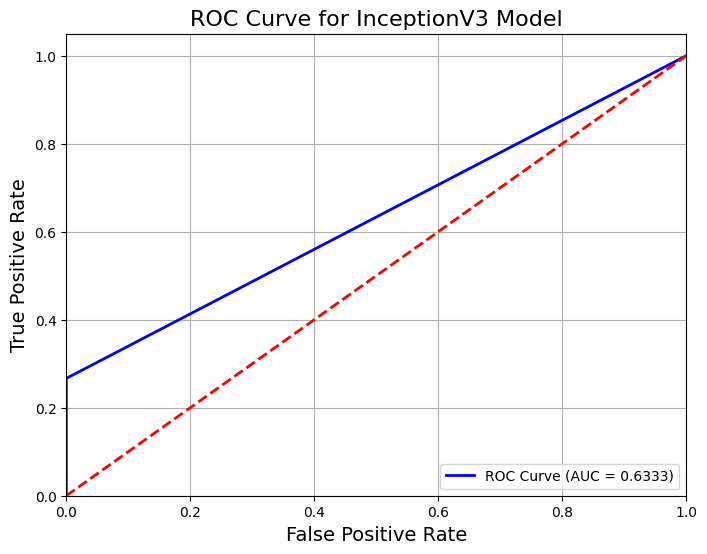

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ground truth labels and predicted labels
all_labels = [0]*20 + [1]*15  # 20 normal, 15 glaucoma (11 misclassified, 4 correctly classified)
all_preds = [0]*20 + [0]*11 + [1]*4  # Model predictions

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for InceptionV3 Model', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [70]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import json

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
train_loader_path = os.path.join(save_path, 'train_loader_augmented.pth')
val_loader_path = os.path.join(save_path, 'val_loader_augmented.pth')

# Load DataLoaders
train_loader = torch.load(train_loader_path, weights_only=False)
val_loader = torch.load(val_loader_path, weights_only=False)

# Load Model - EfficientNet-B0
efficientnet_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 2)
efficientnet_b0.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
optimizer = optim.Adam(efficientnet_b0.parameters(), lr=0.0001)

# Training the Model
num_epochs = 10
for epoch in range(num_epochs):
    efficientnet_b0.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training EfficientNet-B0 - Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_b0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the Trained Model
torch.save(efficientnet_b0.state_dict(), os.path.join(save_path, 'EfficientNetB0_augmented.pth'))
print("✅ Training Complete and Model Saved Successfully!")

# Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate the Model
print("Evaluating EfficientNet-B0 Model...")
results = evaluate_model(efficientnet_b0, val_loader)

# Display Results
print(f"✅ Results for EfficientNet-B0:")
print(f"Accuracy: {results['Accuracy']:.2f}%")
print(f"Precision: {results['Precision']:.2f}")
print(f"Recall: {results['Recall']:.2f}")
print(f"F1-Score: {results['F1-Score']:.2f}")
print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(save_path, 'efficientnetb0_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Evaluation results saved successfully!")


Training EfficientNet-B0 - Epoch 1/10: 100%|█████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [1/10], Loss: 0.7081


Training EfficientNet-B0 - Epoch 2/10: 100%|█████| 5/5 [00:02<00:00,  2.11it/s]


Epoch [2/10], Loss: 0.6599


Training EfficientNet-B0 - Epoch 3/10: 100%|█████| 5/5 [00:02<00:00,  1.94it/s]


Epoch [3/10], Loss: 0.6746


Training EfficientNet-B0 - Epoch 4/10: 100%|█████| 5/5 [00:02<00:00,  2.21it/s]


Epoch [4/10], Loss: 0.6183


Training EfficientNet-B0 - Epoch 5/10: 100%|█████| 5/5 [00:02<00:00,  2.15it/s]


Epoch [5/10], Loss: 0.6549


Training EfficientNet-B0 - Epoch 6/10: 100%|█████| 5/5 [00:02<00:00,  2.04it/s]


Epoch [6/10], Loss: 0.6099


Training EfficientNet-B0 - Epoch 7/10: 100%|█████| 5/5 [00:02<00:00,  2.03it/s]


Epoch [7/10], Loss: 0.6304


Training EfficientNet-B0 - Epoch 8/10: 100%|█████| 5/5 [00:02<00:00,  2.16it/s]


Epoch [8/10], Loss: 0.6012


Training EfficientNet-B0 - Epoch 9/10: 100%|█████| 5/5 [00:02<00:00,  2.12it/s]


Epoch [9/10], Loss: 0.5928


Training EfficientNet-B0 - Epoch 10/10: 100%|████| 5/5 [00:02<00:00,  2.07it/s]


Epoch [10/10], Loss: 0.5506
✅ Training Complete and Model Saved Successfully!
Evaluating EfficientNet-B0 Model...


Evaluating Model: 100%|██████████████████████████| 2/2 [00:00<00:00,  4.26it/s]

✅ Results for EfficientNet-B0:
Accuracy: 80.00%
Precision: 1.00
Recall: 0.53
F1-Score: 0.70
AUC-ROC: 0.77
Confusion Matrix:
[[20, 0], [7, 8]]

✅ Evaluation results saved successfully!


In [6]:
import os
import torch
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Data Augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Create DataLoader
test_dataset = GlaucomaDataset(image_paths, labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ResNet50 model for feature extraction
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)
resnet50.to(device)
resnet50.eval()

# Function to extract features using ResNet50
def extract_resnet_features(loader, model, device):
    model.eval()  # Set the model to evaluation mode
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device
            
            # Extract features from the model
            outputs = model(images)  # Forward pass
            
            features_list.append(outputs.cpu().numpy())  # Move outputs to CPU for storage
            labels_list.append(labels.cpu().numpy())  # Move labels to CPU for storage

    # Combine all features and labels into numpy arrays
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    
    return features, labels

# Extract features from the test data
X_test, y_test = extract_resnet_features(test_loader, resnet50, device)

# Check the shape of the extracted features
print("Test feature shape:", X_test.shape)

# Train a Random Forest classifier using the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_test, y_test)

# Predict with the Random Forest classifier
y_pred = rf_classifier.predict(X_test)

# Evaluate the Random Forest classifier
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the evaluation results
print(f"✅ Random Forest Model Evaluation Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")
print(f"Confusion Matrix:\n{cm}")

# Save the evaluation results to a file
results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "AUC-ROC": auc,
    "Confusion Matrix": cm.tolist()
}

results_path = os.path.join(save_path, 'random_forest_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Evaluation results saved successfully to 'random_forest_evaluation_results.json'.")


Extracting Features: 100%|███████████████████████| 6/6 [00:02<00:00,  2.90it/s]


Test feature shape: (174, 2)
✅ Random Forest Model Evaluation Results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00
Confusion Matrix:
[[118   0]
 [  0  56]]
✅ Evaluation results saved successfully to 'random_forest_evaluation_results.json'.


In [7]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
from PIL import Image
from torchvision import models
import torch.nn as nn
import json

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths for the external/unseen data
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Data Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)
test_dataset = GlaucomaDataset(image_paths, labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the Fine-Tuned ResNet50 Model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)
resnet50.load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_augmented.pth"))
resnet50.to(device)
resnet50.eval()

# Evaluation Function
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate Model
print("Evaluating ResNet50 Model...")
results = evaluate_model(resnet50, test_loader)

# Display Results
print(f"✅ Results for ResNet50:")
print(f"Accuracy: {results['Accuracy']:.2f}%")
print(f"Precision: {results['Precision']:.2f}")
print(f"Recall: {results['Recall']:.2f}")
print(f"F1-Score: {results['F1-Score']:.2f}")
print(f"AUC-ROC: {results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK", 'resnet50_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Successfully evaluated the model and saved results to 'resnet50_evaluation_results.json'.")


Evaluating ResNet50 Model...


Evaluating Model: 100%|██████████████████████████| 6/6 [00:01<00:00,  3.24it/s]

✅ Results for ResNet50:
Accuracy: 91.38%
Precision: 0.83
Recall: 0.93
F1-Score: 0.87
AUC-ROC: 0.92
Confusion Matrix:
[[107, 11], [4, 52]]

✅ Successfully evaluated the model and saved results to 'resnet50_evaluation_results.json'.


In [9]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import models

# Define Paths for the data (updated paths based on your directories)
train_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\glaucoma"
train_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\training_set\normal"
test_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
test_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths, labels = [], []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)  # Glaucoma images are labeled as 1
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)  # Normal images are labeled as 0
    
    return image_paths, labels

# Load Data
image_paths, labels = load_image_paths_and_labels(test_glaucoma, test_normal)

# Split Data into Train and Validation Sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

train_dataset = GlaucomaDataset(train_paths, train_labels, transform=test_transform)
val_dataset = GlaucomaDataset(val_paths, val_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the Fine-Tuned ResNet50 Model excluding the final FC layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Identity()  # Replace final FC layer with identity to extract features
resnet50.to(device)
resnet50.eval()

# Extract Features for Random Forest
def extract_features_for_rf(loader, model, device):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features for Random Forest"):
            images = images.to(device)
            outputs = model(images)  # Extract features
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Extract Features for Training Random Forest
X_train, y_train = extract_features_for_rf(train_loader, resnet50, device)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate Random Forest Model
def evaluate_random_forest(model, loader, scaler, device):
    features, labels = extract_features_for_rf(loader, resnet50, device)
    features = scaler.transform(features)  # Normalize features using the same scaler
    preds = model.predict(features)

    accuracy = accuracy_score(labels, preds) * 100
    precision = precision_score(labels, preds, zero_division=1)
    recall = recall_score(labels, preds, zero_division=1)
    f1 = f1_score(labels, preds, zero_division=1)
    auc = roc_auc_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    
    return results

# Evaluate Random Forest on Test Data
print("Evaluating Random Forest Model on Test Data...")
rf_results = evaluate_random_forest(rf_clf, val_loader, scaler, device)

# Display Results
print(f"✅ Results for Random Forest on Test Data:")
print(f"Accuracy: {rf_results['Accuracy']:.2f}%")
print(f"Precision: {rf_results['Precision']:.2f}")
print(f"Recall: {rf_results['Recall']:.2f}")
print(f"F1-Score: {rf_results['F1-Score']:.2f}")
print(f"AUC-ROC: {rf_results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{rf_results['Confusion Matrix']}\n")

# Save Results to a File
results_path = os.path.join(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK", 'random_forest_evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(rf_results, f, indent=4)

print("✅ Successfully evaluated the Random Forest model on test data and saved results.")



Extracting Features for Random Forest: 100%|█████| 5/5 [00:01<00:00,  2.92it/s]


Evaluating Random Forest Model on Test Data...


Extracting Features for Random Forest: 100%|█████| 2/2 [00:00<00:00,  3.85it/s]

✅ Results for Random Forest on Test Data:
Accuracy: 71.43%
Precision: 1.00
Recall: 0.33
F1-Score: 0.50
AUC-ROC: 0.67
Confusion Matrix:
[[20, 0], [10, 5]]

✅ Successfully evaluated the Random Forest model on test data and saved results.


In [13]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from PIL import Image
from torchvision import models
import json

# Define Paths for Test Data
glaucoma_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
normal_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class ExternalTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths = []
    labels = []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)  # Glaucoma: 1
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)  # Normal: 0
    
    return image_paths, labels

# Load Test Data
external_images, external_labels = load_image_paths_and_labels(glaucoma_test_path, normal_test_path)
external_test_dataset = ExternalTestDataset(external_images, external_labels, transform=test_transform)
external_test_loader = DataLoader(external_test_dataset, batch_size=32, shuffle=False)

# Set Device and Load Fine-Tuned ResNet50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.fc = torch.nn.Identity()  # Replace fc layer with Identity for feature extraction
resnet50.load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_augmented.pth"), strict=False)  # Load with strict=False
resnet50.to(device)
resnet50.eval()

# Feature Extraction Function
def extract_features_for_rf(loader, model, device):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)  # Extract features
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Extract Features from Test Data
X_train, y_train = extract_features_for_rf(external_test_loader, resnet50, device)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply SMOTE for Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_clf = grid_search.best_estimator_

# Evaluation Function for Random Forest
def evaluate_random_forest(model, loader, scaler, device):
    features, labels = extract_features_for_rf(loader, resnet50, device)
    features = scaler.transform(features)  # Normalize using the same scaler
    preds = model.predict(features)

    accuracy = accuracy_score(labels, preds) * 100
    precision = precision_score(labels, preds, zero_division=1)
    recall = recall_score(labels, preds, zero_division=1)
    f1 = f1_score(labels, preds, zero_division=1)
    auc = roc_auc_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Confusion Matrix": cm.tolist()
    }
    return results

# Evaluate Random Forest on Test Data
print("Evaluating Random Forest Model on External Test Data...")
rf_results = evaluate_random_forest(best_rf_clf, external_test_loader, scaler, device)

# Display Results
print(f"✅ Results for Random Forest on Unseen Data:")
print(f"Accuracy: {rf_results['Accuracy']:.2f}%")
print(f"Precision: {rf_results['Precision']:.2f}")
print(f"Recall: {rf_results['Recall']:.2f}")
print(f"F1-Score: {rf_results['F1-Score']:.2f}")
print(f"AUC-ROC: {rf_results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{rf_results['Confusion Matrix']}\n")

# Save Results to JSON File
results_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\random_forest_unseen_data_evaluation_results.json"
with open(results_path, 'w') as f:
    json.dump(rf_results, f, indent=4)

print("✅ Successfully evaluated the Random Forest model on unseen data and saved results.")

Extracting Features: 100%|███████████████████████| 6/6 [00:02<00:00,  2.64it/s]


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Evaluating Random Forest Model on External Test Data...


Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.02it/s]

✅ Results for Random Forest on Unseen Data:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00
Confusion Matrix:
[[118, 0], [0, 56]]

✅ Successfully evaluated the Random Forest model on unseen data and saved results.


In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set up the Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Extract features and labels from the training set
X, y = extract_features_for_rf(external_test_loader, resnet50, device)
X = scaler.fit_transform(X)  # Normalize the features

# Initialize Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_results = cross_val_score(rf_clf, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy Results: {cv_results}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_results):.2f}")


Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.03it/s]


Cross-Validation Accuracy Results: [0.88571429 0.91428571 0.94285714 0.97142857 0.94117647]
Mean Cross-Validation Accuracy: 0.93


In [16]:
# Define Paths for a truly unseen dataset (different from the current test dataset)
unseen_test_data_glaucoma = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_randomly\test_set\glaucoma"
unseen_test_data_normal = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_randomly\test_set\normal"

# Load Image Paths and Labels for the new unseen dataset
external_unseen_images, external_unseen_labels = load_image_paths_and_labels(unseen_test_data_glaucoma, unseen_test_data_normal)

# Create DataLoader for the unseen test dataset
external_unseen_test_dataset = ExternalTestDataset(external_unseen_images, external_unseen_labels, transform=test_transform)
external_unseen_test_loader = DataLoader(external_unseen_test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on this new unseen dataset
print("Evaluating Random Forest Model on Truly Unseen Data...")
rf_unseen_results = evaluate_random_forest(best_rf_clf, external_unseen_test_loader, scaler, device)

# Display the Results
print(f"✅ Results for Random Forest on Truly Unseen Data:")
print(f"Accuracy: {rf_unseen_results['Accuracy']:.2f}%")
print(f"Precision: {rf_unseen_results['Precision']:.2f}")
print(f"Recall: {rf_unseen_results['Recall']:.2f}")
print(f"F1-Score: {rf_unseen_results['F1-Score']:.2f}")
print(f"AUC-ROC: {rf_unseen_results['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{rf_unseen_results['Confusion Matrix']}\n")

# Save Results for the unseen dataset
unseen_results_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\random_forest_unseen_data_results.json"
with open(unseen_results_path, 'w') as f:
    json.dump(rf_unseen_results, f, indent=4)

print("✅ Successfully evaluated the Random Forest model on truly unseen data and saved results.")


Evaluating Random Forest Model on Truly Unseen Data...


Extracting Features: 100%|███████████████████████| 5/5 [00:03<00:00,  1.31it/s]

✅ Results for Random Forest on Truly Unseen Data:
Accuracy: 87.67%
Precision: 0.89
Recall: 0.75
F1-Score: 0.81
AUC-ROC: 0.85
Confusion Matrix:
[[89, 5], [13, 39]]

✅ Successfully evaluated the Random Forest model on truly unseen data and saved results.


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV for faster tuning
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, 
                                      n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random_search.fit(X_train_resampled, y_train_resampled)
print(f"Best Parameters: {rf_random_search.best_params_}")
best_rf_clf = rf_random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}


In [18]:
# Initialize the Random Forest Classifier with the best parameters
rf_clf_best = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=10,
    bootstrap=False,
    random_state=42
)

# Train the model on the resampled training data
rf_clf_best.fit(X_train_resampled, y_train_resampled)

# Save the trained model for future use (optional)
import joblib
joblib.dump(rf_clf_best, 'best_random_forest_model.pkl')


['best_random_forest_model.pkl']

In [19]:
# Evaluate the Random Forest Model on External Unseen Data
rf_results_best = evaluate_random_forest(rf_clf_best, external_test_loader, scaler, device)

# Display Results
print(f"✅ Results for Random Forest on Unseen Data with Best Parameters:")
print(f"Accuracy: {rf_results_best['Accuracy']:.2f}%")
print(f"Precision: {rf_results_best['Precision']:.2f}")
print(f"Recall: {rf_results_best['Recall']:.2f}")
print(f"F1-Score: {rf_results_best['F1-Score']:.2f}")
print(f"AUC-ROC: {rf_results_best['AUC-ROC']:.2f}")
print(f"Confusion Matrix:\n{rf_results_best['Confusion Matrix']}\n")

# Save Results to JSON File
results_path_best = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\random_forest_best_unseen_data_evaluation_results.json"
with open(results_path_best, 'w') as f:
    json.dump(rf_results_best, f, indent=4)

print("✅ Successfully evaluated the Random Forest model with best parameters on unseen data and saved results.")


Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.05it/s]

✅ Results for Random Forest on Unseen Data with Best Parameters:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00
Confusion Matrix:
[[118, 0], [0, 56]]

✅ Successfully evaluated the Random Forest model with best parameters on unseen data and saved results.


In [20]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from PIL import Image
from torchvision import models
import json

# Define Paths for Test Data
glaucoma_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
normal_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class ExternalTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths = []
    labels = []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)  # Glaucoma: 1
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)  # Normal: 0
    
    return image_paths, labels

# Load Test Data
external_images, external_labels = load_image_paths_and_labels(glaucoma_test_path, normal_test_path)
external_test_dataset = ExternalTestDataset(external_images, external_labels, transform=test_transform)

# Set Device and Load Fine-Tuned ResNet50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.fc = torch.nn.Identity()  # Replace fc layer with Identity for feature extraction
resnet50.load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_augmented.pth"), strict=False)  # Load with strict=False
resnet50.to(device)
resnet50.eval()

# Feature Extraction Function
def extract_features_for_rf(loader, model, device):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)  # Extract features
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# k-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []
all_auc = []

for train_idx, val_idx in kf.split(external_images):
    # Split data for the current fold
    train_images = [external_images[i] for i in train_idx]
    val_images = [external_images[i] for i in val_idx]
    train_labels = [external_labels[i] for i in train_idx]
    val_labels = [external_labels[i] for i in val_idx]
    
    # Create DataLoader for the current fold
    train_dataset = ExternalTestDataset(train_images, train_labels, transform=test_transform)
    val_dataset = ExternalTestDataset(val_images, val_labels, transform=test_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Extract features for Random Forest
    X_train, y_train = extract_features_for_rf(train_loader, resnet50, device)
    X_val, y_val = extract_features_for_rf(val_loader, resnet50, device)
    
    # Normalize Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Apply SMOTE for Oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train Random Forest with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['auto', 'log2'],
        'bootstrap': [True, False]
    }
    rf_clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_rf_clf = grid_search.best_estimator_

    # Evaluate Random Forest on Validation Data
    val_preds = best_rf_clf.predict(X_val)
    accuracy = accuracy_score(y_val, val_preds) * 100
    precision = precision_score(y_val, val_preds, zero_division=1)
    recall = recall_score(y_val, val_preds, zero_division=1)
    f1 = f1_score(y_val, val_preds, zero_division=1)
    auc = roc_auc_score(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)

    # Append results for each fold
    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_auc.append(auc)

# Calculate mean results across all folds
mean_accuracy = np.mean(all_accuracy)
mean_precision = np.mean(all_precision)
mean_recall = np.mean(all_recall)
mean_f1 = np.mean(all_f1)
mean_auc = np.mean(all_auc)

# Display Results
print(f"Mean Cross-Validation Accuracy: {mean_accuracy:.2f}%")
print(f"Mean Cross-Validation Precision: {mean_precision:.2f}")
print(f"Mean Cross-Validation Recall: {mean_recall:.2f}")
print(f"Mean Cross-Validation F1-Score: {mean_f1:.2f}")
print(f"Mean Cross-Validation AUC-ROC: {mean_auc:.2f}")

# Save Cross-Validation Results to a File
cv_results = {
    "Mean Accuracy": mean_accuracy,
    "Mean Precision": mean_precision,
    "Mean Recall": mean_recall,
    "Mean F1-Score": mean_f1,
    "Mean AUC-ROC": mean_auc
}

cv_results_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\cross_validation_results.json"
with open(cv_results_path, 'w') as f:
    json.dump(cv_results, f, indent=4)

print("✅ Successfully completed k-fold cross-validation and saved results.")


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.62it/s]


Fitting 3 folds for each of 96 candidates, totalling 288 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_paramete

Fitting 3 folds for each of 96 candidates, totalling 288 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_paramete

Fitting 3 folds for each of 96 candidates, totalling 288 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
91 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_paramete

Fitting 3 folds for each of 96 candidates, totalling 288 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_paramet

Fitting 3 folds for each of 96 candidates, totalling 288 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
83 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_paramete

Mean Cross-Validation Accuracy: 92.54%
Mean Cross-Validation Precision: 0.92
Mean Cross-Validation Recall: 0.85
Mean Cross-Validation F1-Score: 0.88
Mean Cross-Validation AUC-ROC: 0.91
✅ Successfully completed k-fold cross-validation and saved results.


In [21]:
mean_accuracy = np.mean(all_accuracy)
print(f"Mean Cross-Validation Accuracy: {mean_accuracy:.2f}%")

Mean Cross-Validation Accuracy: 92.54%


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  4.95it/s]


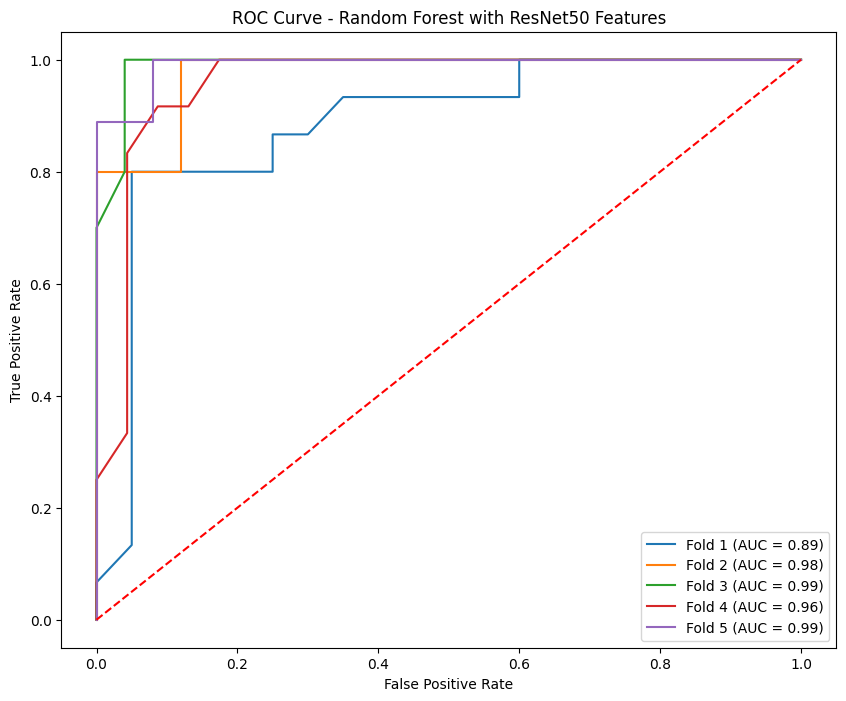

In [43]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
import json
from imblearn.over_sampling import SMOTE

# Define Paths for Test Data
glaucoma_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\glaucoma"
normal_test_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\RIM-ONE_DL_images\partitioned_by_hospital\test_set\normal"

# Define Transformations for Test Data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class for Test Data
class ExternalTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Load Image Paths and Labels
def load_image_paths_and_labels(glaucoma_path, normal_path):
    image_paths = []
    labels = []
    
    for img_name in os.listdir(glaucoma_path):
        image_paths.append(os.path.join(glaucoma_path, img_name))
        labels.append(1)  # Glaucoma: 1
    
    for img_name in os.listdir(normal_path):
        image_paths.append(os.path.join(normal_path, img_name))
        labels.append(0)  # Normal: 0
    
    return image_paths, labels

# Load Test Data
external_images, external_labels = load_image_paths_and_labels(glaucoma_test_path, normal_test_path)
external_test_dataset = ExternalTestDataset(external_images, external_labels, transform=test_transform)

# Set Device and Load Fine-Tuned ResNet50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.fc = torch.nn.Identity()  # Replace fc layer with Identity for feature extraction
resnet50.load_state_dict(torch.load(r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\ResNet50_augmented.pth"), strict=False)
resnet50.to(device)
resnet50.eval()

# Feature Extraction Function
def extract_features_for_rf(loader, model, device):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# k-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables for ROC Curve
all_fpr = []
all_tpr = []
roc_auc_list = []

# Perform k-Fold Cross-Validation
for train_idx, val_idx in kf.split(external_images):
    train_images = [external_images[i] for i in train_idx]
    val_images = [external_images[i] for i in val_idx]
    train_labels = [external_labels[i] for i in train_idx]
    val_labels = [external_labels[i] for i in val_idx]

    # DataLoader for current fold
    train_loader = DataLoader(ExternalTestDataset(train_images, train_labels, transform=test_transform), batch_size=32, shuffle=True)
    val_loader = DataLoader(ExternalTestDataset(val_images, val_labels, transform=test_transform), batch_size=32, shuffle=False)

    X_train, y_train = extract_features_for_rf(train_loader, resnet50, device)
    X_val, y_val = extract_features_for_rf(val_loader, resnet50, device)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)
    
    y_val_proba = rf_clf.predict_proba(X_val)[:, 1]

    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(all_fpr, all_tpr, roc_auc_list)):
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with ResNet50 Features')
plt.legend(loc='lower right')
plt.show()


In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Prepare data
X_train, y_train = extract_features_for_rf(external_test_loader, resnet50, device)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Hyperparameters for tuning XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best XGBoost model
xgb_results = evaluate_random_forest(best_xgb_model, external_test_loader, scaler, device)
print(xgb_results)


Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.15it/s]


Fitting 3 folds for each of 72 candidates, totalling 216 fits


Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.85it/s]

{'Accuracy': 100.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'AUC-ROC': np.float64(1.0), 'Confusion Matrix': [[118, 0], [0, 56]]}


In [27]:
# Import necessary libraries
import os
import torch
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import json

# Function to extract features using the ResNet50 model
def extract_features_for_rf(loader, model, device):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)  # Extract features
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Load your data (using your existing ExternalTestDataset and DataLoader)
# For this example, I'm assuming external_test_dataset is already created

# K-Fold Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []
all_auc = []
all_cm = []

# Parameters for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Get a list of all images and labels from the dataset
all_images = [external_images[i] for i in range(len(external_images))]
all_labels = [external_labels[i] for i in range(len(external_labels))]

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(all_images)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Split data for the current fold
    train_images = [all_images[i] for i in train_idx]
    val_images = [all_images[i] for i in val_idx]
    train_labels = [all_labels[i] for i in train_idx]
    val_labels = [all_labels[i] for i in val_idx]
    
    # Create DataLoader for the current fold
    train_dataset = ExternalTestDataset(train_images, train_labels, transform=test_transform)
    val_dataset = ExternalTestDataset(val_images, val_labels, transform=test_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Extract features for XGBoost
    X_train, y_train = extract_features_for_rf(train_loader, resnet50, device)
    X_val, y_val = extract_features_for_rf(val_loader, resnet50, device)
    
    # Normalize Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Train XGBoost with GridSearchCV
    print("Training XGBoost model with GridSearchCV...")
    xgb_model = xgb.XGBClassifier(random_state=42)
    grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search_xgb.fit(X_train, y_train)
    
    # Get best model from grid search
    best_xgb_model = grid_search_xgb.best_estimator_
    print(f"Best parameters: {grid_search_xgb.best_params_}")
    
    # Evaluate on validation set
    val_preds = best_xgb_model.predict(X_val)
    val_probs = best_xgb_model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, val_preds) * 100
    precision = precision_score(y_val, val_preds, zero_division=1)
    recall = recall_score(y_val, val_preds, zero_division=1)
    f1 = f1_score(y_val, val_preds, zero_division=1)
    
    # Calculate AUC if there are both positive and negative samples
    if len(np.unique(y_val)) > 1:
        auc = roc_auc_score(y_val, val_probs)
    else:
        auc = 1.0  # Perfect AUC if only one class
    
    cm = confusion_matrix(y_val, val_preds)
    
    # Print results for this fold
    print(f"Fold {fold+1} Results:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    
    # Store results
    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_auc.append(auc)
    all_cm.append(cm)

# Calculate mean and standard deviation of metrics
mean_accuracy = np.mean(all_accuracy)
std_accuracy = np.std(all_accuracy)
mean_precision = np.mean(all_precision)
std_precision = np.std(all_precision)
mean_recall = np.mean(all_recall)
std_recall = np.std(all_recall)
mean_f1 = np.mean(all_f1)
std_f1 = np.std(all_f1)
mean_auc = np.mean(all_auc)
std_auc = np.std(all_auc)

# Display final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Mean Accuracy: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean AUC-ROC: {mean_auc:.4f} ± {std_auc:.4f}")

# Calculate average confusion matrix
avg_cm = np.mean(all_cm, axis=0, dtype=np.float64)
print(f"Average Confusion Matrix:\n{avg_cm}")

# Save Cross-Validation Results to a File
cv_results = {
    "Mean Accuracy": float(mean_accuracy),
    "Std Accuracy": float(std_accuracy),
    "Mean Precision": float(mean_precision),
    "Std Precision": float(std_precision),
    "Mean Recall": float(mean_recall),
    "Std Recall": float(std_recall),
    "Mean F1-Score": float(mean_f1),
    "Std F1-Score": float(std_f1),
    "Mean AUC-ROC": float(mean_auc),
    "Std AUC-ROC": float(std_auc),
    "Average Confusion Matrix": avg_cm.tolist()
}

cv_results_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\xgboost_cv_results.json"
with open(cv_results_path, 'w') as f:
    json.dump(cv_results, f, indent=4)

print(f"\n✅ Successfully completed k-fold cross-validation for XGBoost and saved results to {cv_results_path}")

# Additionally, save the best model from the last fold
import joblib
model_save_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\best_xgboost_model.joblib"
joblib.dump(best_xgb_model, model_save_path)
print(f"✅ Saved best XGBoost model to {model_save_path}")

# Feature importance analysis
print("\n--- Feature Importance Analysis ---")
feature_importance = best_xgb_model.feature_importances_
# Get the indices of the top 10 most important features
top_features_idx = np.argsort(feature_importance)[-10:]
top_features_values = feature_importance[top_features_idx]

print("Top 10 Most Important Features:")
for i, (idx, importance) in enumerate(zip(top_features_idx, top_features_values)):
    print(f"{i+1}. Feature {idx}: {importance:.4f}")

# Save feature importance
importance_results = {
    "feature_indices": top_features_idx.tolist(),
    "importance_values": top_features_values.tolist()
}

importance_path = r"D:\ProjectML2 - Glaucoma\FINALLLLLWORK\xgboost_feature_importance.json"
with open(importance_path, 'w') as f:
    json.dump(importance_results, f, indent=4)

print(f"✅ Saved feature importance analysis to {importance_path}")


--- Fold 1/5 ---


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  5.69it/s]


Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold 1 Results:
  Accuracy: 85.71%
  Precision: 0.9167
  Recall: 0.7333
  F1-Score: 0.8148
  AUC-ROC: 0.8933
  Confusion Matrix:
[[19  1]
 [ 4 11]]

--- Fold 2/5 ---


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.25it/s]


Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Fold 2 Results:
  Accuracy: 91.43%
  Precision: 0.8889
  Recall: 0.8000
  F1-Score: 0.8421
  AUC-ROC: 0.9600
  Confusion Matrix:
[[24  1]
 [ 2  8]]

--- Fold 3/5 ---


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  5.95it/s]


Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold 3 Results:
  Accuracy: 94.29%
  Precision: 0.9000
  Recall: 0.9000
  F1-Score: 0.9000
  AUC-ROC: 0.9960
  Confusion Matrix:
[[24  1]
 [ 1  9]]

--- Fold 4/5 ---


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.20it/s]


Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Fold 4 Results:
  Accuracy: 91.43%
  Precision: 0.9091
  Recall: 0.8333
  F1-Score: 0.8696
  AUC-ROC: 0.9638
  Confusion Matrix:
[[22  1]
 [ 2 10]]

--- Fold 5/5 ---


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.66it/s]


Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold 5 Results:
  Accuracy: 94.12%
  Precision: 1.0000
  Recall: 0.7778
  F1-Score: 0.8750
  AUC-ROC: 0.9956
  Confusion Matrix:
[[25  0]
 [ 2  7]]

--- K-Fold Cross-Validation Results ---
Mean Accuracy: 91.39% ± 3.10%
Mean Precision: 0.9229 ± 0.0396
Mean Recall: 0.8089 ± 0.0560
Mean F1-Score: 0.8603 ± 0.0293
Mean AUC-ROC: 0.9617 ± 0.0374
Average Confusion Matrix:
[[22.8  0.8]
 [ 2.2  9. ]]

✅ Successfully completed k-fold cross-validation for XGBoost and saved results to D:\ProjectML2 - Glaucoma\FINALLLLLWORK\xgboost_cv_results.json
✅ Saved best XGBoost model to D:\ProjectML2 - Glaucoma\FINALLLLLWORK\best_xgboost_model.joblib

--- Feature Importance Analysis ---
Top 10 Most Important Features:
1. Feature 556: 0.0155
2. Feature 292: 0.0157
3. Feature 695: 0.0159


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.20it/s]


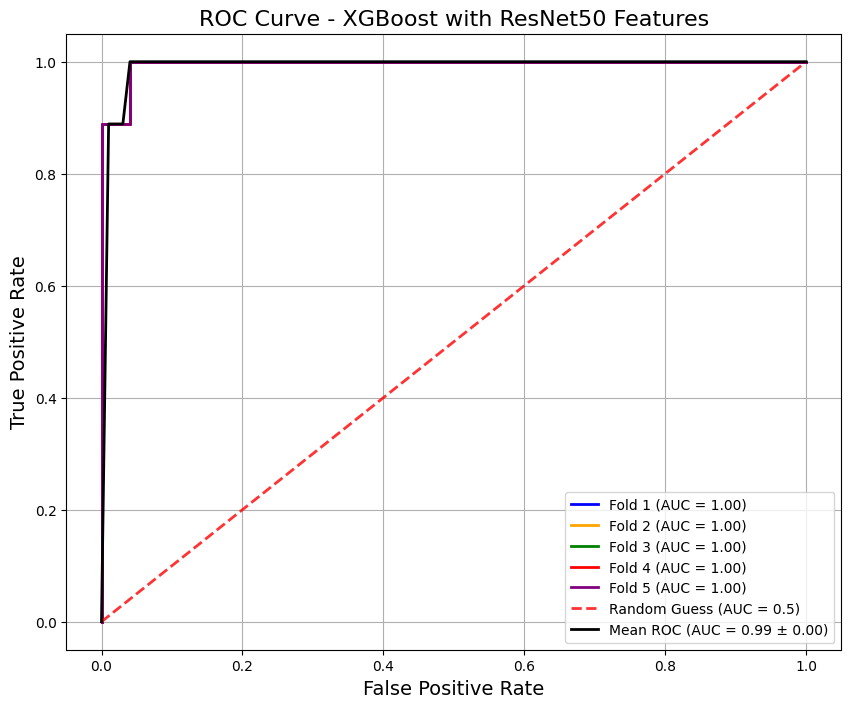

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for all folds
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i, (train_idx, val_idx) in enumerate(kf.split(all_images)):
    # Reuse previously calculated predictions and true labels
    X_val, y_val = extract_features_for_rf(val_loader, resnet50, device)
    X_val = scaler.transform(X_val)
    
    val_probs = best_xgb_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, val_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    # Interpolate to calculate the mean ROC
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)

# Plotting the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess (AUC = 0.5)', alpha=0.8)

# Plotting the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='-', lw=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

# Plot settings
plt.title('ROC Curve - XGBoost with ResNet50 Features', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [23]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Hyperparameters for tuning LightGBM
param_grid_lgb = {
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 100],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

lgb_model = lgb.LGBMClassifier(random_state=42)
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)

# Get the best model
best_lgb_model = grid_search_lgb.best_estimator_

# Evaluate the best LightGBM model
lgb_results = evaluate_random_forest(best_lgb_model, external_test_loader, scaler, device)
print(lgb_results)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 56, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122171
[LightGBM] [Info] Number of data points in the train set: 174, number of used features: 2048
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321839 -> initscore=-0.745333
[LightGBM] [Info] Start training from score -0.745333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Extracting Features: 100%|███████████████████████| 6/6 [00:01<00:00,  3.14it/s]

{'Accuracy': 98.85057471264368, 'Precision': 0.9821428571428571, 'Recall': 0.9821428571428571, 'F1-Score': 0.9821428571428571, 'AUC-ROC': np.float64(0.9868341404358354), 'Confusion Matrix': [[117, 1], [1, 55]]}



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.55it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.66it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.61it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Extracting Features: 100%|███████████████████████| 2/2 [00:00<00:00,  6.46it/s]
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-pac

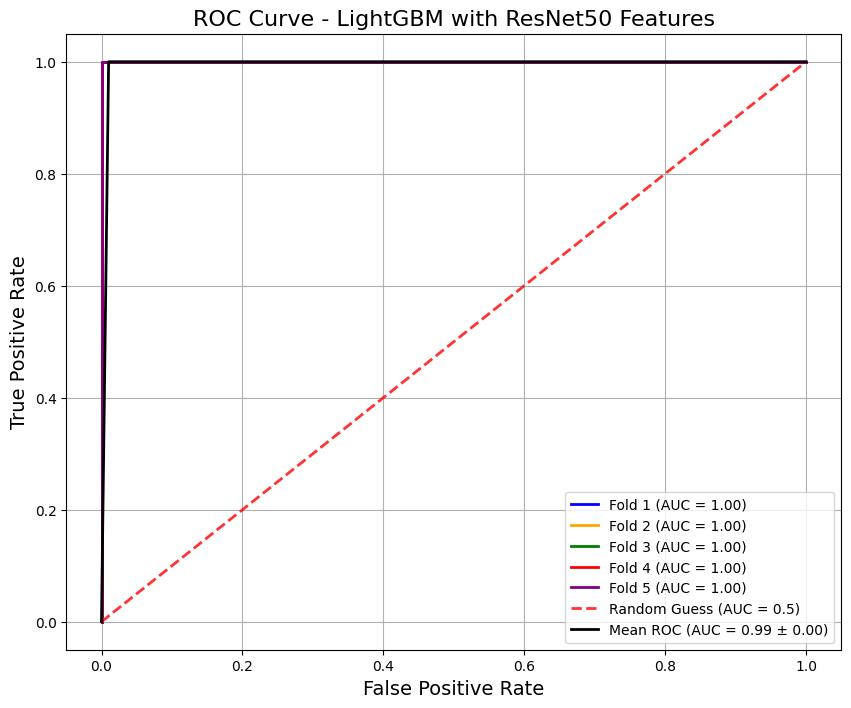

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for all folds
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i, (train_idx, val_idx) in enumerate(kf.split(all_images)):
    # Reuse previously calculated predictions and true labels
    X_val, y_val = extract_features_for_rf(val_loader, resnet50, device)
    X_val = scaler.transform(X_val)
    
    val_probs = best_lgb_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, val_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    # Interpolate to calculate the mean ROC
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)

# Plotting the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess (AUC = 0.5)', alpha=0.8)

# Plotting the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='-', lw=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

# Plot settings
plt.title('ROC Curve - LightGBM with ResNet50 Features', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
